# North Atlantic SST composites - Downstream analysis with SST tendencies


## 1. Load Python libraries

In [2]:
import numpy as np
from numpy import *
import bisect
import scipy as sp
from scipy.stats import gaussian_kde, ttest_ind
import numpy.matlib 
import math
from scipy import signal
import xarray as xr
from xarray import DataArray
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.rasterize_and_save as raster
import cartopy
import cartopy.crs as ccrs
from datetime import timedelta
import datetime
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## 2. Load data sets 

In [3]:
ds_ERA5_SST = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__sea_surface_temperature__1979-2019.nc')
ds_ERA5_z = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__z300hPa__1979-2019.nc')
ds_ERA5_T2M = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__2m_temperature__1979-2019.nc')
ds_ERA5_SST_old = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__sea_surface_temperature__1979-2019.nc')
ds_ERA5_lathf = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_latent_heat_flux__1979-2019.nc')
ds_ERA5_senhf = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_sensible_heat_flux__1979-2019.nc')
ds_ERA5_tcc = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__total_cloud_cover__1979-2019.nc')
ds_ERA5_snsr = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_net_solar_radiation__1979-2019.nc')
ds_ERA5_sntr = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_net_thermal_radiation__1979-2019.nc')
ds_ERA5_z_PW_RWP = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5_300hPa_z_1979-2019__filtered-PW-RWP.nc')
ds_ERA5_cp = xr.open_dataset('/data/user/jukrueger/ERA5/ERA5_conv_precip_1979_2019_daymean_2_5_deg_06_00_00.nc')
ds_ERA5_evap = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__evaporation_1979_2019_daymean_2_5_deg_06_00_00_inverted.nc')
ds_ERA5_lsp = xr.open_dataset('/data/user/jukrueger/ERA5/ERA5__large_scale_precipitation__1979-2019_06_00.nc')
ds_ERA5_tp = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__total_precipitation__1979-2019.nc')
ds_ERA5_lcc = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__low_cloud_cover_1979_2019_daymean_2_5_deg_06_00_inverted.nc')
ds_ERA5_mcc = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__medium_cloud_cover_1979_2019_daymean_2_5_deg_06_00_inverted.nc')
ds_ERA5_hcc = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__high_cloud_cover_1979_2019_daymean_2_5_deg_06_00_inverted.nc')
ds_ERA5_vv700 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__vertical_velocity_700hPa__1979_2019.nc')
ds_ERA5_vv600 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__vertical_velocity_600hPa__1979_2019.nc')
ds_ERA5_vv500 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__vertical_velocity_500hPa__1979_2019.nc')
ds_ERA5_t300 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__300hPa_temperature__1979_2019.nc')
ds_ERA5_u300 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__u_300hPa__1979_2019.nc')
ds_ERA5_v300 = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__v_300hPa__1979_2019.nc')

In [4]:
print(ds_ERA5_tp)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 73, lon: 144, time: 14975)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:30:00 ... 2019-12-31T06:00:00
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    var228     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jan 12 15:40:23 2022: cdo shifttime,-30min ERA5__total_...
    institution:  European Centre for Medium-Range Weather Forecasts
    frequency:    day
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


## 3. SST for composite dates calculation

* Deseasonalize
* Calc mean of North Atlantic box
* Select only JJA values
* add 'year' coordinate for composite calculation later
* Calc quantiles

In [5]:
##### Deseasonalize SST data: Subtract difference between the means of each day and the whole time mean
sst_deseason = ds_ERA5_SST.var34.groupby("time.dayofyear") - (ds_ERA5_SST.var34.groupby("time.dayofyear").mean("time", skipna=False) - ds_ERA5_SST.var34.mean('time', skipna=False))
t2m_deseason = ds_ERA5_T2M.var167.groupby("time.dayofyear") - (ds_ERA5_T2M.var167.groupby("time.dayofyear").mean("time") - ds_ERA5_T2M.var167.mean('time'))

########## Calculation for SST and T2M Map ###########
##### Connect SSt and T2M
sst_t2m = ds_ERA5_SST_old.var34.where(ds_ERA5_SST_old.var34 >= -8.999999873090293e+33, ds_ERA5_T2M.var167)
#print(ds_ERA5_SST_old.var34[0,36,0:10])
#print(ds_ERA5_T2M.var167[0,36,0:10])
#print(sst_t2m[0,36,0:10])
##### Deseasonalize SST data: Subtract difference between the means of each day and the whole time mean
sst_t2m_deseason = sst_t2m.groupby("time.dayofyear") - (sst_t2m.groupby("time.dayofyear").mean("time") - sst_t2m.mean('time'))
# Detrend data set 
sst_t2m_detrend = signal.detrend(sst_t2m_deseason, axis=0)
# Produce xarray Data Array
sst_t2m_detrend_xr =  xr.DataArray(data=sst_t2m_detrend, dims=["time", "lat", "lon"], coords=dict(lon = ds_ERA5_SST.lon,lat= ds_ERA5_SST.lat, time=ds_ERA5_SST.time))                                                                                               
# Calc climatology
sst_t2m_detrend_clim = sst_t2m_detrend_xr.groupby('time.season').mean('time')
# Calc detrended JJA anomalies
sst_t2m_JJA_anom = sst_t2m_detrend_xr.resample(time="QS-DEC").mean()[2::4] - sst_t2m_detrend_clim.sel(season='JJA')
# ...only for 2018
years = [str(int(n)) for n in np.linspace(1979,2019,41)]
sst_t2m_detrend_xr_append=[]
for i in range(41):
    sst_t2m_detrend_xr_append.append(sst_t2m_detrend_xr.sel(time=slice(years[i]+'-07-12 11:30:00', years[i]+'-08-08 11:30:00')))

sst_t2m_detrend_xr_concat= xr.concat(sst_t2m_detrend_xr_append,dim='time').mean('time')
sst_t2m_2018_JJA_anom = sst_t2m_detrend_xr.sel(time=slice('2018-07-12 11:30:00','2018-08-08 11:30:00')).mean('time') - sst_t2m_detrend_xr_concat
######################################################


##### Calc North Atlantic weighted mean over 45-60°N / 15-40°W:
weights = np.cos(np.deg2rad(ds_ERA5_SST.lat))
sst_Atl = sst_deseason.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat')
t2m_Euro = t2m_deseason.sel(lon=slice(0, 20.0), lat=slice(52.5, 45.0)).weighted(weights).mean('lon').mean('lat')
# Old NAO Index - Seasaw of Temperatures
t2m_Ilulissat = t2m_deseason.sel(lon=slice(310.0, 310.0), lat=slice(70.0, 70.0)).weighted(weights).mean('lon').mean('lat')
t2m_Vienna = t2m_deseason.sel(lon=slice(15.0, 15.0), lat=slice(47.5, 47.5)).weighted(weights).mean('lon').mean('lat')

#############################
# Detrend data set 
sst_Atl_ds_dt = signal.detrend(sst_Atl, axis=0)
t2m_Euro_ds_dt = signal.detrend(t2m_Euro, axis=0)
# Old NAO Index - Seasaw of Temperatures
t2m_Ilulissat_ds_dt = signal.detrend(t2m_Ilulissat, axis=0)
t2m_Vienna_ds_dt = signal.detrend(t2m_Vienna, axis=0)

# Produce xarray Data Array
sst_Atl_ds_dt_xr =  xr.DataArray(data=sst_Atl_ds_dt, dims=["time"], coords=dict(time=ds_ERA5_SST.time)) 
t2m_Euro_ds_dt_xr =  xr.DataArray(data=t2m_Euro_ds_dt, dims=["time"], coords=dict(time=ds_ERA5_T2M.time)) 
# Old NAO Index - Seasaw of Temperatures
t2m_Ilulissat_ds_dt_xr =  xr.DataArray(data=t2m_Ilulissat_ds_dt, dims=["time"], coords=dict(time=ds_ERA5_SST.time)) 
t2m_Vienna_ds_dt_xr =  xr.DataArray(data=t2m_Vienna_ds_dt, dims=["time"], coords=dict(time=ds_ERA5_T2M.time)) 
#############################

############################
###### Produce lagged relationship with all values first and then select JJA values: Produce scatter plot of 3772 SST & T2M  with lags from -10 to +10
sst_lags_all = []
sst_lags_all_JJA = []
start_sst = 0
end_sst = 14955
lags = [str(int(n)) for n in np.linspace(-10,10,21)]

for i in range(21):
    sst_lags_all.append(sst_Atl_ds_dt_xr[start_sst:end_sst]) #.where(t2m_Euro_ds_dt_xr.time ==((sst_Atl_ds_dt_xr.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=t2m_Euro_ds_dt_xr.time + pd.Timedelta(lags[i]+" days")))))
    sst_lags_all[i].coords['lead_lag'] = int(lags[i])
    sst_lags_all[i].coords['time'] = t2m_Euro_ds_dt_xr[10:14965].time
    sst_lags_all_JJA.append(sst_lags_all[i].sel(time=sst_lags_all[i]['time.season']==['JJA']))
    start_sst+=1
    end_sst+=1

sst_lags_all_JJA_set = xr.DataArray(np.stack(sst_lags_all_JJA, axis=0),dims=["lead_lag", "time"],coords=dict(lead_lag= [int(n) for n in np.linspace(-10,10,21)], time = sst_lags_all_JJA[0].time))
print(sst_lags_all_JJA_set)
##############################

##### Select only JJA values
sst_deseason_Atl_JJA = sst_Atl_ds_dt_xr.sel(time=sst_Atl['time.season']==['JJA'])
t2m_deseason_Euro_JJA = t2m_Euro_ds_dt_xr.sel(time=t2m_Euro['time.season']==['JJA'])
# Old NAO Index - Seasaw of Temperatures
t2m_Ilulissat_ds_dt_xr_JJA = t2m_Ilulissat_ds_dt_xr.sel(time=sst_Atl['time.season']==['JJA'])
t2m_Vienna_ds_dt_xr_JJA = t2m_Vienna_ds_dt_xr.sel(time=t2m_Euro['time.season']==['JJA'])

##### JJA maximum
t2m_deseason_Euro_JJA_max = t2m_deseason_Euro_JJA.groupby('time.year').max('time')

##### JJA seasonal mean
sst_deseason_Atl_JJA_mean = sst_deseason_Atl_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - sst_Atl.mean('time')
t2m_deseason_Euro_JJA_mean = t2m_deseason_Euro_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - t2m_Euro.mean('time')
# Old NAO Index - Seasaw of Temperatures
t2m_Ilulissat_ds_dt_xr_JJA_mean = t2m_Ilulissat_ds_dt_xr_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - sst_Atl.mean('time')
t2m_Vienna_ds_dt_xr_JJA_mean = t2m_Vienna_ds_dt_xr_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - t2m_Euro.mean('time')

print(t2m_deseason_Euro_JJA)

##### Add coordinate 'Year' to the data set 
A=xr.DataArray(np.full((92), 1979))
years=[]
for i in range(len(sst_deseason_Atl_JJA_mean)):
    years.append(A)
    A=A+1
years_array = xr.concat(years, dim='dim_0')
sst_deseason_Atl_JJA = sst_deseason_Atl_JJA.assign_coords(year=('time',years_array))

##### Calc quantiles
quantile_10 = sst_deseason_Atl_JJA.quantile(0.1, dim='time')
quantile_50 = sst_deseason_Atl_JJA.quantile(0.5, dim='time')
quantile_90 = sst_deseason_Atl_JJA.quantile(0.9, dim='time')
print(quantile_10)
print(quantile_50)
print(quantile_90)

<xarray.DataArray (lead_lag: 21, time: 3772)>
array([[-0.01808995, -0.07827394, -0.16338841, ...,  0.09793093,
        -0.04800507,  0.05409906],
       [-0.07827394, -0.16338841, -0.21457288, ..., -0.04800507,
         0.05409906,  0.05000162],
       [-0.16338841, -0.21457288, -0.26679337, ...,  0.05409906,
         0.05000162,  0.0211251 ],
       ...,
       [ 0.1011791 ,  0.13185426,  0.17990621, ..., -0.05327772,
        -0.0821364 , -0.04161674],
       [ 0.13185426,  0.17990621,  0.29870188, ..., -0.0821364 ,
        -0.04161674,  0.01493971],
       [ 0.17990621,  0.29870188,  0.42416345, ..., -0.04161674,
         0.01493971,  0.00284508]])
Coordinates:
  * lead_lag  (lead_lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 3 4 5 6 7 8 9 10
  * time      (time) datetime64[ns] 1979-06-01T06:00:00 ... 2019-08-31T06:00:00
<xarray.DataArray (time: 3772)>
array([4.72244994, 4.91874092, 5.29290361, ..., 3.58626295, 3.45774179,
       4.30047815])
Coordinates:
  * time       (time) datetime6

*  Composite criteria
 * Two events need to be 30 days apart from each other and
 * date has to be the start of a cold, medium or warm period and 
 * the 6 following days are above or below the same quantile threshold as well

In [6]:
sst_ds_Atl_JJA_cold_negtend=[]
sst_ds_Atl_JJA_cold_postend=[]
sst_ds_Atl_JJA_medium_negtend=[]
sst_ds_Atl_JJA_warm_negtend=[]
sst_ds_Atl_JJA_warm_postend=[]

for i in range(0, len(sst_deseason_Atl_JJA)-5):
    j=np.array([i,i+1,i+2])
    if np.all(sst_deseason_Atl_JJA[j] < quantile_10) and sst_deseason_Atl_JJA[i-1] > quantile_10 and sst_deseason_Atl_JJA[i-1].time.year == sst_deseason_Atl_JJA[i].time.year and sst_deseason_Atl_JJA[i+2].time.year == sst_deseason_Atl_JJA[i].time.year: 
        if sst_ds_Atl_JJA_cold_negtend == []:  
            sst_ds_Atl_JJA_cold_negtend.append(sst_deseason_Atl_JJA[i])
        elif sst_ds_Atl_JJA_cold_negtend[-1].time < (sst_deseason_Atl_JJA[i].time - pd.Timedelta("30 days")):
            sst_ds_Atl_JJA_cold_negtend.append(sst_deseason_Atl_JJA[i])

    if np.all(sst_deseason_Atl_JJA[j] > quantile_10) and sst_deseason_Atl_JJA[i-1] < quantile_10 and sst_deseason_Atl_JJA[i-1].time.year == sst_deseason_Atl_JJA[i].time.year  and sst_deseason_Atl_JJA[i+2].time.year == sst_deseason_Atl_JJA[i].time.year:
        if sst_ds_Atl_JJA_cold_postend == []:  
            sst_ds_Atl_JJA_cold_postend.append(sst_deseason_Atl_JJA[i])
        elif sst_ds_Atl_JJA_cold_postend[-1].time < (sst_deseason_Atl_JJA[i].time - pd.Timedelta("30 days")):
            sst_ds_Atl_JJA_cold_postend.append(sst_deseason_Atl_JJA[i])
        
    if np.all(sst_deseason_Atl_JJA[j] < quantile_50) and sst_deseason_Atl_JJA[i-1] > quantile_50 and sst_deseason_Atl_JJA[i-1].time.year == sst_deseason_Atl_JJA[i].time.year and sst_deseason_Atl_JJA[i+2].time.year == sst_deseason_Atl_JJA[i].time.year:
        if sst_ds_Atl_JJA_medium_negtend == []:  
            sst_ds_Atl_JJA_medium_negtend.append(sst_deseason_Atl_JJA[i])
        elif sst_ds_Atl_JJA_medium_negtend[-1].time < (sst_deseason_Atl_JJA[i].time - pd.Timedelta("30 days")):
            sst_ds_Atl_JJA_medium_negtend.append(sst_deseason_Atl_JJA[i])

    if np.all(sst_deseason_Atl_JJA[j] < quantile_90) and sst_deseason_Atl_JJA[i-1] > quantile_90 and sst_deseason_Atl_JJA[i-1].time.year == sst_deseason_Atl_JJA[i].time.year  and sst_deseason_Atl_JJA[i+2].time.year == sst_deseason_Atl_JJA[i].time.year:
        if sst_ds_Atl_JJA_warm_negtend == []:  
            sst_ds_Atl_JJA_warm_negtend.append(sst_deseason_Atl_JJA[i])
        elif sst_ds_Atl_JJA_warm_negtend[-1].time < (sst_deseason_Atl_JJA[i].time - pd.Timedelta("30 days")):
            sst_ds_Atl_JJA_warm_negtend.append(sst_deseason_Atl_JJA[i])
        
    if np.all(sst_deseason_Atl_JJA[j] > quantile_90) and sst_deseason_Atl_JJA[i-1] < quantile_90 and sst_deseason_Atl_JJA[i-1].time.year == sst_deseason_Atl_JJA[i].time.year  and sst_deseason_Atl_JJA[i+2].time.year == sst_deseason_Atl_JJA[i].time.year:
        if sst_ds_Atl_JJA_warm_postend == []:  
            sst_ds_Atl_JJA_warm_postend.append(sst_deseason_Atl_JJA[i])
        elif sst_ds_Atl_JJA_warm_postend[-1].time < (sst_deseason_Atl_JJA[i].time - pd.Timedelta("30 days")):
            sst_ds_Atl_JJA_warm_postend.append(sst_deseason_Atl_JJA[i])
        
sst_ds_Atl_JJA_cold_negtend_concat = xr.concat(sst_ds_Atl_JJA_cold_negtend, dim='time')
sst_ds_Atl_JJA_cold_postend_concat = xr.concat(sst_ds_Atl_JJA_cold_postend, dim='time')
sst_ds_Atl_JJA_medium_negtend_concat = xr.concat(sst_ds_Atl_JJA_medium_negtend, dim='time')
sst_ds_Atl_JJA_warm_negtend_concat = xr.concat(sst_ds_Atl_JJA_warm_negtend, dim='time')
sst_ds_Atl_JJA_warm_postend_concat = xr.concat(sst_ds_Atl_JJA_warm_postend, dim='time')

print(sst_ds_Atl_JJA_cold_negtend_concat.time.dt.strftime("%d/%m/%Y"))
print(sst_ds_Atl_JJA_cold_postend_concat.time.dt.strftime("%d/%m/%Y"))
print(sst_ds_Atl_JJA_medium_negtend_concat.time.dt.strftime("%d/%m/%Y"))
print(sst_ds_Atl_JJA_warm_negtend_concat.time.dt.strftime("%d/%m/%Y"))
print(sst_ds_Atl_JJA_warm_postend_concat.time.dt.strftime("%d/%m/%Y"))

<xarray.DataArray 'strftime' (time: 12)>
array(['03/08/1985', '27/07/1986', '06/08/1988', '28/07/1992',
       '21/06/1994', '19/06/2002', '26/08/2009', '05/07/2011',
       '25/06/2015', '29/07/2017', '16/06/2018', '26/07/2018'],
      dtype=object)
Coordinates:
  * time       (time) datetime64[ns] 1985-08-03T06:00:00 ... 2018-07-26T06:00:00
    dayofyear  (time) int64 215 208 219 210 172 170 238 186 176 210 167 207
    year       (time) int64 1985 1986 1988 1992 1994 ... 2015 2017 2018 2018
<xarray.DataArray 'strftime' (time: 12)>
array(['28/06/1986', '26/08/1986', '14/08/1988', '25/06/2002',
       '07/08/2009', '24/07/2010', '10/07/2011', '09/06/2015',
       '25/06/2017', '11/08/2017', '07/06/2018', '23/07/2018'],
      dtype=object)
Coordinates:
  * time       (time) datetime64[ns] 1986-06-28T06:00:00 ... 2018-07-23T06:00:00
    dayofyear  (time) int64 179 238 227 176 219 205 191 160 176 223 158 204
    year       (time) int64 1986 1986 1988 2002 2009 ... 2017 2017 2018 2018
<xar

* Show Plots of North Atlantic SST data
 * Raw data vs Linear detrended data
 * only JJA values, highlight quantile thresholds and events of each composite
 * Bar plot with JJA seasonal mean values

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


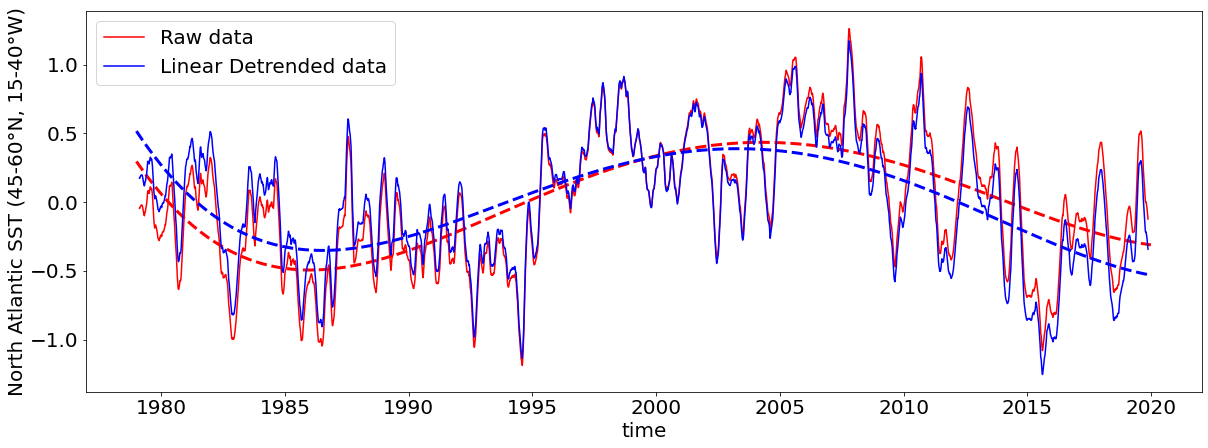

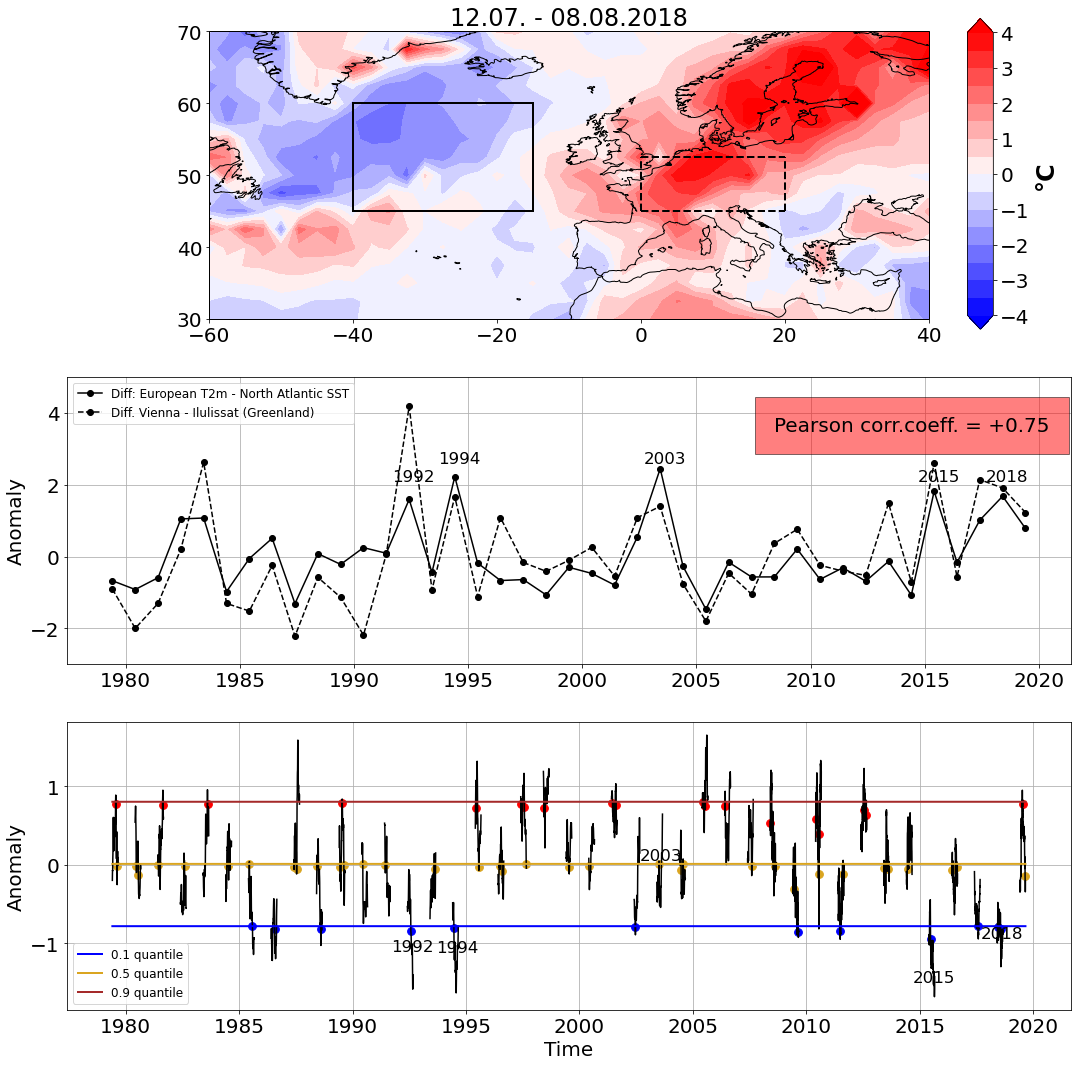

In [7]:
# Set general font size
plt.rcParams['font.size'] = '20'

########### Show the difference between the initial data and the detrended data with cdo or scipy.signal.detrend
x_JJA= range(len(sst_deseason_Atl_JJA.time))
x=range(14975)
sst_Atl_anom = sst_Atl - sst_Atl.mean('time')
z1 = np.polyfit(x,sst_Atl_anom , 4)
poly1 = np.poly1d(z1)
z2 = np.polyfit(x,sst_Atl_ds_dt_xr, 4)
poly2 = np.poly1d(z2)

rm_val = 90
sst_data = [sst_Atl_anom, xr.DataArray(sst_Atl_ds_dt_xr,dims=['time'], coords=dict(time=sst_Atl_anom.time))]
poly_data = [poly1, poly2]
color=['red','blue']
labels = ['Raw data','Linear Detrended data']
fig = plt.figure(figsize=(20,7))
for i in range(0,2):
    plt.plot(sst_Atl.rolling(time=rm_val, center=True).mean().dropna("time").time, sst_data[i].rolling(time=rm_val, center=True).mean().dropna("time"),color=color[i], label=labels[i])
    plt.plot(sst_Atl.time,poly_data[i](x),color=color[i], ls='--', lw=3)
    plt.ylabel('North Atlantic SST (45-60°N, 15-40°W)')
    plt.xlabel('time')
plt.legend()
plt.savefig('ERA5_SST_deseason_Atl_box_detrended_1979_2019.pdf')

fig = plt.figure(figsize=(18,18))
prj = ccrs.PlateCarree()
axs=[]
for i in range(1,4):
    if i==1:
        axs.append(fig.add_subplot(3,1,i, projection=prj))
    else:
        axs.append(fig.add_subplot(3,1,i))
levels= np.linspace(-4,4, 17)
X, Y = np.meshgrid(np.linspace(0,360, 145), ds_ERA5_SST.lat)
p1 = axs[0].contourf(X, Y,np.c_[sst_t2m_2018_JJA_anom, sst_t2m_2018_JJA_anom[:,0]], cmap='bwr', transform=prj,levels = levels, extend='both')
cb_ax = fig.add_axes([0.82, 0.65, 0.02, 0.24])
cb = fig.colorbar(p1, cax=cb_ax, orientation='vertical')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='°C', size='large', weight='bold')
axs[0].coastlines('50m')
axs[0].set_xticks([-80, -60, -40, -20,0,20, 40, 60, 80],crs=prj)
axs[0].set_yticks([30,40, 50, 60, 70,80],crs=prj)
axs[0].set_title('12.07. - 08.08.2018')
axs[0].set_extent([-60, 40, 30, 70], ccrs.PlateCarree())
# Show SST boxes
x1, y1 = [-40, -15], [45, 45]
x2, y2 = [-40, -15], [60, 60]
x3, y3 = [-40, -40], [45, 60]
x4, y4 = [-15, -15], [45, 60]
axs[0].plot(x1, y1, x2, y2,x3,y3,x4,y4, color='black', linestyle='-', linewidth=2)
# Show T2M boxes
x1_E, y1_E = [0, 20], [45, 45]
x2_E, y2_E = [0, 20], [52.5, 52.5]
x3_E, y3_E = [0, 0], [45, 52.5]
x4_E, y4_E = [20, 20], [45, 52.5]
axs[0].plot(x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='--', linewidth=2)

years = [str(int(n)) for n in np.linspace(1979,2019,41)]
hw_years= ['1992','1994','2003','2015','2018']
sst_event_dots= [sst_ds_Atl_JJA_cold_negtend_concat, sst_ds_Atl_JJA_warm_negtend_concat, sst_ds_Atl_JJA_medium_negtend_concat]
color_dots= ['blue','red','goldenrod']
quantiles=[quantile_10, quantile_50, quantile_90]
color_lines= ['blue','goldenrod', 'brown']
label= ['0.1','0.5','0.9']
for i in range(41):
    axs[2].plot(sst_deseason_Atl_JJA.time.sel(time=slice(years[i]+'-06-01T06:00:00', years[i]+'-08-31T06:00:00')), sst_deseason_Atl_JJA.sel(time=slice(years[i]+'-06-01T06:00:00', years[i]+'-08-31T06:00:00')),color='black')
for i in range(0,len(sst_event_dots)):
    axs[2].scatter(sst_event_dots[i].time, sst_event_dots[i], color=color_dots[i], s=60)
for i in range(0,len(quantiles)):
    axs[2].plot(sst_deseason_Atl_JJA.time, [quantiles[i]]*len(sst_deseason_Atl_JJA.time), color=color_lines[i], lw=2, label=label[i]+' quantile')
for i in range(0,len(hw_years)):
    axs[2].text(sst_deseason_Atl_JJA.time.sel(time=slice(hw_years[i]+'-08-15T06:00:00',hw_years[i]+'-08-15T06:00:00')), sst_deseason_Atl_JJA.sel(time=slice(hw_years[i]+'-08-15T06:00:00',hw_years[i]+'-08-15T06:00:00')),hw_years[i], fontsize='small', horizontalalignment='center', verticalalignment='bottom')
#plt.title('Detrended data - only JJA values')
axs[2].set_ylabel('Anomaly')
#axs[1].set_xlabel('Time')
axs[2].legend(fontsize=12, loc=3)
#plt.savefig('ERA5_SST_deseason_Atl_box_JJA_events_highlighted_detrended_1979_2019.pdf')
#plt.plot([1978,2020],[0,0], color='black', ls='--', lw=2)
#axs[1].plot(t2m_deseason_Euro_JJA_mean.time, t2m_deseason_Euro_JJA_mean,color='red')
axs[2].grid()

#for i in range(41):
#    axs[2].plot(t2m_deseason_Euro_JJA.time.sel(time=slice(years[i]+'-06-01T06:00:00', years[i]+'-08-31T06:00:00')), t2m_deseason_Euro_JJA.sel(time=slice(years[i]+'-06-01T06:00:00', years[i]+'-08-31T06:00:00')),color='black')
axs[1].grid()
#axs[1].plot(t2m_deseason_Euro_JJA_mean.time, t2m_deseason_Euro_JJA_mean,color='red', marker='o', label='European T2m')
#axs[1].plot(sst_deseason_Atl_JJA_mean.time, sst_deseason_Atl_JJA_mean,color='blue', marker='o', label= 'North Atlantic SST')
axs[1].plot(sst_deseason_Atl_JJA_mean.time, t2m_deseason_Euro_JJA_mean - sst_deseason_Atl_JJA_mean,color='black', marker='o', label='Diff: European T2m - North Atlantic SST')
axs[1].plot(t2m_Ilulissat_ds_dt_xr_JJA_mean.time, t2m_Vienna_ds_dt_xr_JJA_mean - t2m_Ilulissat_ds_dt_xr_JJA_mean, color='black', marker='o', ls='--', label= 'Diff. Vienna - Ilulissat (Greenland)')
#axs[1].plot(sst_deseason_Atl_JJA_mean.time, t2m_deseason_Euro_JJA_max,color='red', marker='o', linestyle = '--', label='European T2m Maximum')
c = np.corrcoef((t2m_deseason_Euro_JJA_mean - sst_deseason_Atl_JJA_mean),(t2m_Vienna_ds_dt_xr_JJA_mean - t2m_Ilulissat_ds_dt_xr_JJA_mean))[0,1]
axs[1].set_ylabel('Anomaly')
axs[2].set_xlabel('Time')
height=[2,2.5,2.5,2,2]
for i in range(0,len(hw_years)):
    axs[1].text(sst_deseason_Atl_JJA.time.sel(time=slice(hw_years[i]+'-08-15T06:00:00',hw_years[i]+'-08-15T06:00:00')), height[i],hw_years[i], fontsize='small', horizontalalignment='center', verticalalignment='bottom')
axs[1].set_ylim([-3, 5])
axs[1].legend(fontsize=12, loc='upper left')
axs[1].text(t2m_Ilulissat_ds_dt_xr_JJA_mean.time[29],3.5,"Pearson corr.coeff. = +"+ str("%.2f" % c),
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 19})
#axs[1].plot([sst_deseason_Atl_JJA_mean.time[0],sst_deseason_Atl_JJA_mean.time[-1]],[0,0], color='black', ls='--', lw=2)
#plt.figtext(0.08,0.9,"a)", ha="center", va="top", fontsize=20)
#plt.figtext(0.08,0.63,"b)", ha="center", va="top", fontsize=20)
#plt.figtext(0.08,0.36,"c)", ha="center", va="top", fontsize=20)

rasterize_list = [axs[0], axs[1], axs[2]]
raster.rasterize_and_save('ERA5_figure1_no_labels.pdf', rasterize_list, dpi=300)

## Scatter plots of NA SSTs and T2m plots with different lags

## 4. Lead lag analysis plots: Define functions for ..
* Lat Lon Maps
* Lat Lead Hovmöller 
* Lon Lead Hovmöller
* Box averages - Line plots

In [8]:
def lead_lag(var, rm_value):
    # Detrend data set 
    var_detrend = signal.detrend(var, axis=0)
    # Produce xarray Data Array
    var_detrend_xr =  xr.DataArray(data=var_detrend, dims=["time", "lat", "lon"], coords=dict(lon = var.lon,lat= var.lat, time=var.time)) 
    # Deseasonalize
    var_ds_dt = var_detrend_xr.groupby("time.dayofyear") - (var_detrend_xr.groupby("time.dayofyear").mean("time") - var_detrend_xr.mean('time'))
    # Substract time mean
    var_anom = var_ds_dt - var_ds_dt.mean('time')

    #### Lead lag analysis without any mean
    lags = [str(int(n)) for n in np.linspace(-60,60,121)]
    var_cold_negtend_lags=[]
    var_cold_postend_lags=[]
    var_medium_negtend_lags=[]
    var_warm_negtend_lags=[]
    var_warm_postend_lags=[]
    for i in range(0,len(lags)):
        var_cold_negtend_lags.append(var_anom.where(var_anom.time ==((sst_ds_Atl_JJA_cold_negtend_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=sst_ds_Atl_JJA_cold_negtend_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_cold_postend_lags.append(var_anom.where(var_anom.time ==((sst_ds_Atl_JJA_cold_postend_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=sst_ds_Atl_JJA_cold_postend_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_medium_negtend_lags.append(var_anom.where(var_anom.time ==((sst_ds_Atl_JJA_medium_negtend_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=sst_ds_Atl_JJA_medium_negtend_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_warm_negtend_lags.append(var_anom.where(var_anom.time ==((sst_ds_Atl_JJA_warm_negtend_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=sst_ds_Atl_JJA_warm_negtend_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_warm_postend_lags.append(var_anom.where(var_anom.time ==((sst_ds_Atl_JJA_warm_postend_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=sst_ds_Atl_JJA_warm_postend_concat.time + pd.Timedelta(lags[i]+" days")))))

        var_cold_negtend_lags[i].coords['lead_lag'] = int(lags[i])
        var_cold_postend_lags[i].coords['lead_lag'] = int(lags[i])
        var_medium_negtend_lags[i].coords['lead_lag'] = int(lags[i])
        var_cold_negtend_lags[i].coords['lead_lag'] = int(lags[i])
        var_cold_postend_lags[i].coords['lead_lag'] = int(lags[i])
        
    var_cold_negtend_lags_set = xr.DataArray(np.stack(var_cold_negtend_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_cold_negtend_lags[60].time,lat= var_cold_negtend_lags[0].lat,lon= var_cold_negtend_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_cold_postend_lags_set = xr.DataArray(np.stack(var_cold_postend_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_cold_postend_lags[60].time,lat= var_cold_postend_lags[0].lat, lon= var_cold_postend_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_medium_negtend_lags_set = xr.DataArray(np.stack(var_medium_negtend_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_medium_negtend_lags[60].time,lat= var_medium_negtend_lags[0].lat, lon= var_medium_negtend_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_warm_negtend_lags_set = xr.DataArray(np.stack(var_warm_negtend_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_warm_negtend_lags[60].time,lat= var_warm_negtend_lags[0].lat,lon= var_warm_negtend_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_warm_postend_lags_set = xr.DataArray(np.stack(var_warm_postend_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_warm_postend_lags[60].time,lat= var_warm_postend_lags[0].lat, lon= var_warm_postend_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")

    var_lags_set= [var_cold_negtend_lags_set, var_cold_postend_lags_set, var_medium_negtend_lags_set, var_warm_negtend_lags_set, var_warm_postend_lags_set]
        
    return(var_lags_set)

def maps(var_lags_set, prob_th):
    # time mean -> maps
    var_lags_map= [var_lags_set[i].mean('time') for i in range(5)]
    # without time mean -> maps in terms of probability
    var_lags_map_wtm= [var_lags_set[i] for i in range(5)]
    var_lags_map_prob_pos = [(var_lags_map_wtm[i] > prob_th).sum(dim='time')/len(var_lags_map_wtm[i].time) for i in range(5)]
    var_lags_map_prob_neg = [(var_lags_map_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_map_wtm[i].time) for i in range(5)]
    # t test for maps 
    var_lags_map_welch = [xr.DataArray(ttest_ind(var_lags_set[0], var_lags_set[3], axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat","lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_set[0].lat,lon= var_lags_set[0].lon)), 
                          xr.DataArray(ttest_ind(var_lags_set[1], var_lags_set[4], axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat","lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_set[0].lat,lon= var_lags_set[0].lon))]
    return (var_lags_map,var_lags_map_wtm, var_lags_map_prob_pos)
    
def hov_lat_lead(var_lags_set, prob_th):   
    # lon mean -> Hovmöller lat vs lead plots
    var_lags_Atl_lat_lead = [var_lags_set[i].sel(lon=slice(320.0, 345.0)).mean('lon').mean('time') for i in range(5)]
    var_lags_Euro_lat_lead = [var_lags_set[i].sel(lon=slice(0.0, 20.0)).mean('lon').mean('time') for i in range(5)]
    # without time mean -> Hovmöller plots in terms of probability
    var_lags_Atl_lat_lead_wtm = [var_lags_set[i].sel(lon=slice(320.0, 345.0)).mean('lon') for i in range(5)]
    var_lags_Euro_lat_lead_wtm = [var_lags_set[i].sel(lon=slice(0.0, 20.0)).mean('lon') for i in range(5)]
    var_lags_Atl_lat_lead_prob_pos = [(var_lags_Atl_lat_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Atl_lat_lead_wtm[i].time) for i in range(5)]
    var_lags_Atl_lat_lead_prob_neg = [(var_lags_Atl_lat_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Atl_lat_lead_wtm[i].time) for i in range(5)]
    var_lags_Euro_lat_lead_prob_pos = [(var_lags_Euro_lat_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Euro_lat_lead_wtm[i].time) for i in range(5)]
    var_lags_Euro_lat_lead_prob_neg = [(var_lags_Euro_lat_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Euro_lat_lead_wtm[i].time) for i in range(5)]
    # t test
    var_lags_Atl_lat_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lon=slice(320.0, 345.0)).mean('lon'), var_lags_set[3].sel(lon=slice(320.0, 345.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat)), 
                                   xr.DataArray(ttest_ind(var_lags_set[1].sel(lon=slice(320.0, 345.0)).mean('lon'), var_lags_set[4].sel(lon=slice(320.0, 345.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat))]
    var_lags_Euro_lat_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lon=slice(0.0, 20.0)).mean('lon'), var_lags_set[3].sel(lon=slice(0.0, 20.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat)), 
                                    xr.DataArray(ttest_ind(var_lags_set[1].sel(lon=slice(0.0, 20.0)).mean('lon'), var_lags_set[4].sel(lon=slice(0.0, 20.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat))]
    return(var_lags_Atl_lat_lead, var_lags_Euro_lat_lead, var_lags_Atl_lat_lead_prob_pos, var_lags_Euro_lat_lead_prob_pos)

def hov_lon_lead(var_lags_set, prob_th):    
    # lon mean -> Hovmöller lon vs lead plots
    var_lags_lon_lead = [var_lags_set[i].sel(lat=slice(60.0, 40.0)).mean('lat').mean('time') for i in range(5)]
    # without time mean -> Hovmöller plots in terms of probability
    var_lags_lon_lead_wtm = [var_lags_set[i].sel(lat=slice(60.0, 40.0)).mean('lat') for i in range(5)]
    var_lags_lon_lead_prob_pos = [(var_lags_lon_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_lon_lead_wtm[i].time) for i in range(5)]
    var_lags_lon_lead_prob_neg = [(var_lags_lon_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_lon_lead_wtm[i].time) for i in range(5)]
    # t test
    var_lags_lon_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lat=slice(60.0, 40.0)).mean('lat'), var_lags_set[3].sel(lat=slice(60.0, 40.0)).mean('lat'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lon= var_lags_lon_lead[0].lon)), 
                               xr.DataArray(ttest_ind(var_lags_set[1].sel(lat=slice(60.0, 40.0)).mean('lat'), var_lags_set[4].sel(lat=slice(60.0, 40.0)).mean('lat'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lon= var_lags_lon_lead[0].lon))]
    return(var_lags_lon_lead, var_lags_lon_lead_prob_pos)
def lines(var_lags_set, prob_th):    
    # lon & lat means -> line plots
    var_lags_Atl_line= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).mean('lon').mean('lat', skipna=True).mean('time') for i in range(5)]
    var_lags_Euro_line= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).mean('lon').mean('lat').mean('time') for i in range(5)]
    # without time mean -> Box average line plots in terms of probability
    var_lags_Atl_line_wtm= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).mean('lon').mean('lat') for i in range(5)]
    var_lags_Euro_line_wtm= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).mean('lon').mean('lat') for i in range(5)]
    var_lags_Atl_line_prob_pos = [(var_lags_Atl_line_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Atl_line_wtm[i].time) for i in range(5)]
    var_lags_Atl_line_prob_neg= [(var_lags_Atl_line_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Atl_line_wtm[i].time) for i in range(5)]
    var_lags_Euro_line_prob_pos = [(var_lags_Euro_line_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Euro_line_wtm[i].time) for i in range(5)]
    var_lags_Euro_line_prob_neg = [(var_lags_Euro_line_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Euro_line_wtm[i].time) for i in range(5)]
        
    var_lags_Atl_line_welch = [xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[0], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), 
                               xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[1], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)),
                               xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[3], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)),
                               xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[4], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag))]
    var_lags_Euro_line_welch = [xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[0], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), 
                                xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[1], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), 
                                xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[3], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), 
                                xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[4], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag))]

    return(var_lags_Atl_line,var_lags_Euro_line,var_lags_Atl_line_wtm,var_lags_Euro_line_wtm, var_lags_Atl_line_prob_pos, var_lags_Euro_line_prob_pos)


## 5. Use functions for different parameters

In [9]:
sst_t2m = ds_ERA5_SST_old.var34.where(ds_ERA5_SST_old.var34 >= -8.999999873090293e+33, ds_ERA5_T2M.var167)
SST_T2M =  xr.DataArray(data=sst_t2m, dims=["time", "lat", "lon"], coords=dict(lon = ds_ERA5_SST.lon,lat= ds_ERA5_SST.lat, time=ds_ERA5_SST.time))                                                                                               

z300 = xr.DataArray(ds_ERA5_z.z,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81 

tcc = ds_ERA5_tcc.tcc
lhf = ds_ERA5_lathf.var147/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins = 3600s)
shf = ds_ERA5_senhf.var146/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
snsr = ds_ERA5_snsr.ssr/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
sntr = ds_ERA5_sntr.str/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
lcc = ds_ERA5_lcc.lcc
mcc = ds_ERA5_mcc.mcc
hcc = ds_ERA5_hcc.hcc
lsp = ds_ERA5_lsp.var142*1000*24 # <- convert from m/s to mm/day
cp = ds_ERA5_cp.cp*1000*24 # <- convert from m/s to mm/day
tp = ds_ERA5_tp.var228*1000*24 # <- convert from m/s to mm/day
vv_700_500 = (ds_ERA5_vv700.w + ds_ERA5_vv600.w + ds_ERA5_vv500.w)/3 # vertical integral of vertical velocity between 500 and 700 hPa
t300 = ds_ERA5_t300.t
u300 = ds_ERA5_u300.u 
v300 = ds_ERA5_v300.v
z_RWP  = np.nan_to_num(ds_ERA5_z_PW_RWP.filt_RWP, nan=0.0) # <- fill nan values with zeros
z_RWP = xr.DataArray(z_RWP,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81
z_PW  = np.nan_to_num(ds_ERA5_z_PW_RWP.filt_PW, nan=0.0) # <- fill nan values with zeros
z_PW = xr.DataArray(z_PW,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81

v_lags_set = {}
v_map = {}
v_map_wtm = {}
v_map_prob_pos = {}
v_Atl_lat_lead = {}
v_Euro_lat_lead = {}
v_Atl_lat_lead_prob_pos = {}
v_Euro_lat_lead_prob_pos = {}
v_lon_lead = {}
v_lon_lead_prob_pos = {}
v_Atl_line = {}
v_Euro_line = {}
v_Atl_line_wtm = {}
v_Euro_line_wtm = {}
v_Atl_line_prob_pos = {}
v_Euro_line_prob_pos = {}

v = [SST_T2M, z300, tcc, lhf, shf, snsr, sntr, lcc, mcc, hcc, lsp, cp, tp, vv_700_500, t300, u300, v300, z_RWP, z_PW]
variable= ['sst_t2m', 'z300', 'tcc', 'lhf', 'shf', 'snsr', 'sntr', 'lcc', 'mcc', 'hcc', 'lsp', 'cp','tp', 'vv_700_500', 't300', 'u300', 'v300', 'z_RWP', 'z_PW']
prob_th = 0 # <- set thresholds for probability selection
for i in range(len(v)):
    v_lags_set[variable[i]] = lead_lag(v[i],5) # <- set days for running mean !!!
    v_map[variable[i]], v_map_wtm[variable[i]], v_map_prob_pos[variable[i]] = maps(v_lags_set[variable[i]], prob_th) 
    v_Atl_lat_lead[variable[i]], v_Euro_lat_lead[variable[i]], v_Atl_lat_lead_prob_pos[variable[i]], v_Euro_lat_lead_prob_pos[variable[i]] = hov_lat_lead(v_lags_set[variable[i]], prob_th)
    v_lon_lead[variable[i]], v_lon_lead_prob_pos[variable[i]] = hov_lon_lead(v_lags_set[variable[i]], prob_th)
    v_Atl_line[variable[i]], v_Euro_line[variable[i]], v_Atl_line_wtm[variable[i]], v_Euro_line_wtm[variable[i]], v_Atl_line_prob_pos[variable[i]], v_Euro_line_prob_pos[variable[i]]  = lines(v_lags_set[variable[i]], prob_th)


/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


* SST & T2M

# Plot Maps

In [10]:
# Set p-value thresholds:
upp_p_val=0.1
low_p_val=0.05

In [11]:
# Change colormaps
white = np.array([1., 1., 1., 1.])

################
BuPu = plt.cm.get_cmap('BuPu', 256)
BuPu_white = BuPu(np.linspace(0, 1, 256))
BuPu_white[0:28, :] = white
BuPu_white_cm= ListedColormap(BuPu_white)
################
afmhot_reversed = plt.cm.get_cmap('afmhot',256).reversed()
afmhot_reversed_white = afmhot_reversed(np.linspace(0, 1, 256))
afmhot_reversed_white[0:28, :] = white
afmhot_reversed_white_cm= ListedColormap(afmhot_reversed_white)
###############
seismic = plt.cm.get_cmap('seismic', 256)
seismic_white = seismic(np.linspace(0, 1, 256))
seismic_white[112:144, :] = white
seismic_white_cm= ListedColormap(seismic_white)
##############
PuOr_cmap = plt.cm.get_cmap('PuOr').reversed()
BrBG_cmap = plt.cm.get_cmap('BrBG').reversed()
spectral = plt.cm.get_cmap('Spectral', 256)
spectral_white = spectral(np.linspace(0, 1, 256))
white = np.array([1., 1., 1., 1.])
spectral_white[114:142, :] = white
spectral_white_cm= ListedColormap(spectral_white)
#spectral_white= ListedColormap(["darkred", "red","darkorange", "orange","gold", "white","lightcyan","cyan", "darkcyan","blue","darkblue"])


### Box averages with composite time mean

<xarray.DataArray (lead_lag: 121)>
array([0.68421053, 0.68421053, 0.68421053, 0.68421053, 0.68421053,
       0.68421053, 0.63157895, 0.68421053, 0.73684211, 0.73684211,
       0.73684211, 0.68421053, 0.63157895, 0.73684211, 0.78947368,
       0.84210526, 0.78947368, 0.78947368, 0.78947368, 0.73684211,
       0.78947368, 0.73684211, 0.89473684, 0.84210526, 0.78947368,
       0.84210526, 0.84210526, 0.89473684, 0.89473684, 0.89473684,
       0.89473684, 0.89473684, 0.89473684, 0.84210526, 0.84210526,
       0.89473684, 0.89473684, 0.89473684, 0.84210526, 0.84210526,
       0.84210526, 0.89473684, 0.94736842, 0.94736842, 0.94736842,
       0.94736842, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.94736842, 0.94736842, 0.94736842, 0.94736842,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.      

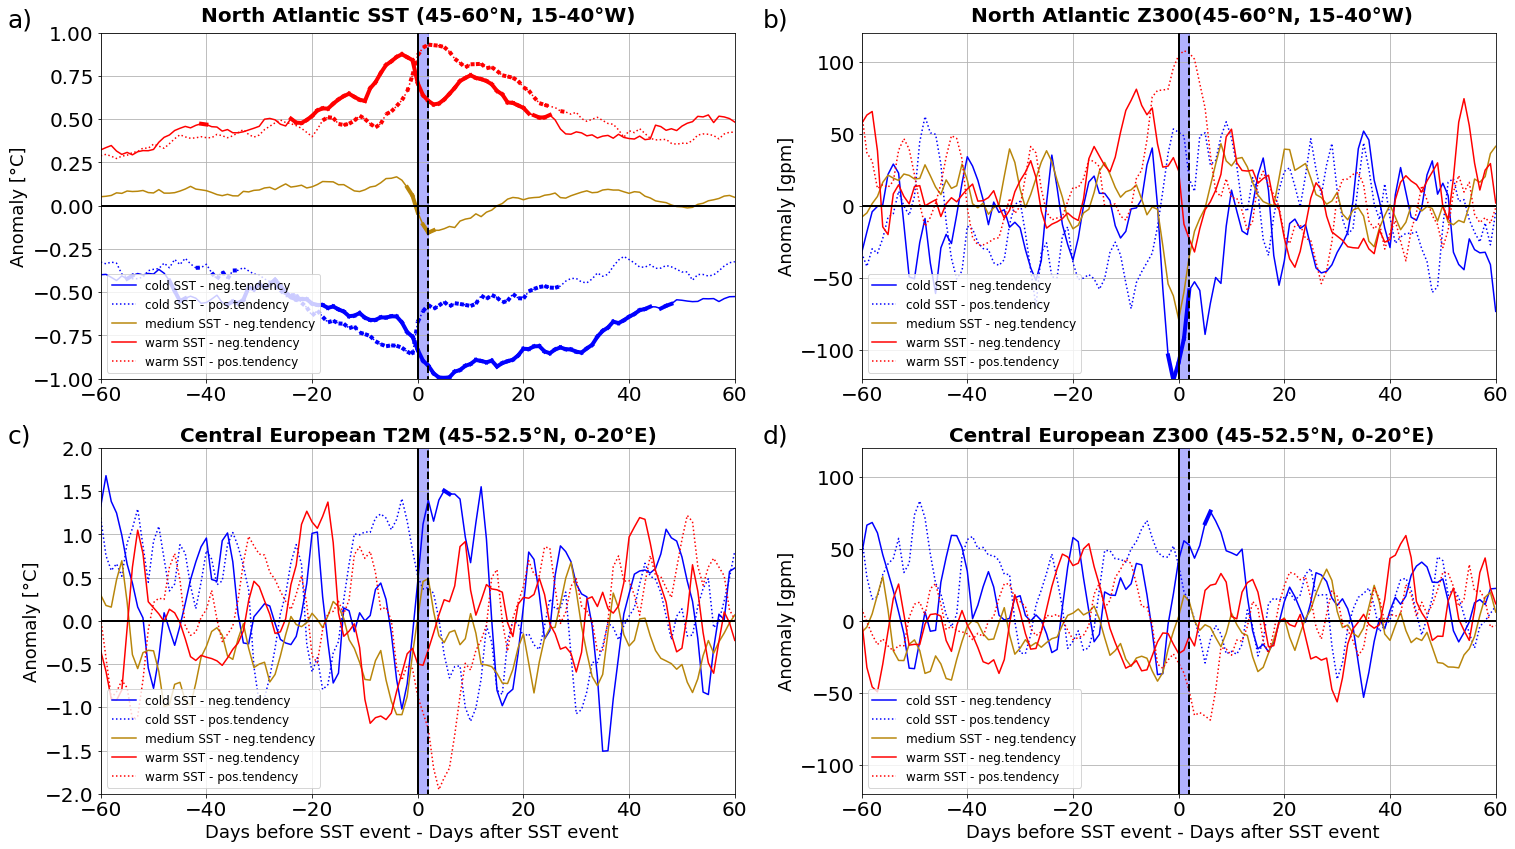

In [12]:
# Set general font size
plt.rcParams['font.size'] = '20'
#### SST und T2M
#files=['ERA5_SST_T2M_composite_lead_lag_Duchez_box_SST_first_val_rm_detrended_1979_2019.pdf' ]
label= ['cold SST - neg.tendency','cold SST - pos.tendency','medium SST - neg.tendency','warm SST - neg.tendency','warm SST - pos.tendency']
style=['-','dotted','-','-','dotted']
color=['blue','blue','darkgoldenrod','red','red']
param_lines = [v_Atl_line['sst_t2m'], v_Atl_line['z300'], v_Euro_line['sst_t2m'], v_Euro_line['z300']]
param_lines_prob= [v_Atl_line_prob_pos['sst_t2m'], v_Atl_line_prob_pos['z300'], v_Euro_line_prob_pos['sst_t2m'], v_Euro_line_prob_pos['z300']]
print(v_Atl_line_prob_pos['sst_t2m'][4])
lag=np.linspace(-60,60,121)
lag_rm=np.linspace(-60,60,121)
fig = plt.figure(figsize=(25,14))
axs=[]
signif_upp = 0.9
signif_low = 0.1
for i in range(1,5):
        axs.append(fig.add_subplot(2,2,i))
for i in range(5):
    for a in range(4):
        axs[a].plot(lag_rm, param_lines[a][i], color =color[i], label=label[i], ls=style[i])
        axs[a].grid()
        for j in range(len(lag_rm)-1):
            if param_lines_prob[a][i][j]>signif_upp or param_lines_prob[a][i][j]<signif_low:
                axs[a].plot([lag_rm[j], lag_rm[j+1]],[param_lines[a][i][j], param_lines[a][i][j+1]], lw=4, color=color[i],ls=style[i])
            #if sst_t2m_Euro_line_prob_neg[i][j]>signif_upp or sst_t2m_Euro_line_prob_neg[i][j]<signif_low:
            #    axs[2].plot([lag_rm[j], lag_rm[j+1]],[sst_t2m_Euro_line[i][j], sst_t2m_Euro_line[i][j+1]], lw=4, color=color[i],ls=style[i])
plt.figtext(0.3013,0.906,"North Atlantic SST (45-60°N, 15-40°W)", ha="center", va="top", fontsize=20, weight='bold')
plt.figtext(0.7313,0.906,"North Atlantic Z300(45-60°N, 15-40°W)", ha="center", va="top", fontsize=20, weight='bold')
plt.figtext(0.3013,0.49,"Central European T2M (45-52.5°N, 0-20°E)", ha="center", va="top", fontsize=20, weight='bold')
plt.figtext(0.7313,0.49,"Central European Z300 (45-52.5°N, 0-20°E)", ha="center", va="top", fontsize=20, weight='bold')

            
for ax in range(4):
    axs[ax].plot([-60, 60], [0, 0], color='black', lw=2)
    axs[ax].axvspan(0, 2, alpha=0.3, color='blue')
    axs[ax].plot([2,2],[-130,130], color='black', ls='--', lw=2)
    axs[ax].plot([0,0], [-130, 130], color='black', lw=2)
    axs[ax].legend(fontsize=12, loc=3)
    #axs[ax].set_xticks([-60,-40,-20,0,20,40,60])
    #axs[ax].set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
    axs[ax].set_xlim([-60,60])
axs[2].set_xlabel('Days before SST event - Days after SST event  ', fontsize=18)
axs[3].set_xlabel('Days before SST event - Days after SST event  ', fontsize=18)
axs[0].set_ylabel('Anomaly [°C]', fontsize=18)
axs[1].set_ylabel('Anomaly [gpm]', fontsize=18)
axs[2].set_ylabel('Anomaly [°C]', fontsize=18)
axs[3].set_ylabel('Anomaly [gpm]', fontsize=18)
axs[0].set_ylim([-1,1])
axs[1].set_ylim([-120,120])
axs[2].set_ylim([-2,2])
axs[3].set_ylim([-120,120])
plt.figtext(0.08,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.08,0.4925,"c)", ha="center", va="top", fontsize=25)
plt.figtext(0.5,0.905,"b)", ha="center", va="top", fontsize=25)
plt.figtext(0.5,0.4925,"d)", ha="center", va="top", fontsize=25)

rasterize_list = [axs[0], axs[1], axs[2],axs[3]]
raster.rasterize_and_save('ERA5_cold_warm_SST_neg_pos_tendency_lines_probs_SST_T2m_Z300_3consec_days_wrm.pdf', rasterize_list, dpi=300)

In [13]:
################# Produce function that converts from 0-360 to -180 and +180
def wrapTo180(ds,longitude):

    # Adjust lon values to make sure they are within (-180, 180)
    ds['_longitude_wrapped'] = xr.where(longitude > 180., longitude - 360., longitude)

    # reassign the new coords to as the main lon coords
    # and sort DataArray using new coordinate values
    ds = (ds.swap_dims({'lon': '_longitude_wrapped'})
          .sel(**{'_longitude_wrapped': sorted(ds._longitude_wrapped)}).drop('lon'))
    ds = ds.rename({'_longitude_wrapped': 'lon'})
    return ds
##################


### Plot lead/lag vs lon contourf plots: SST&T2M

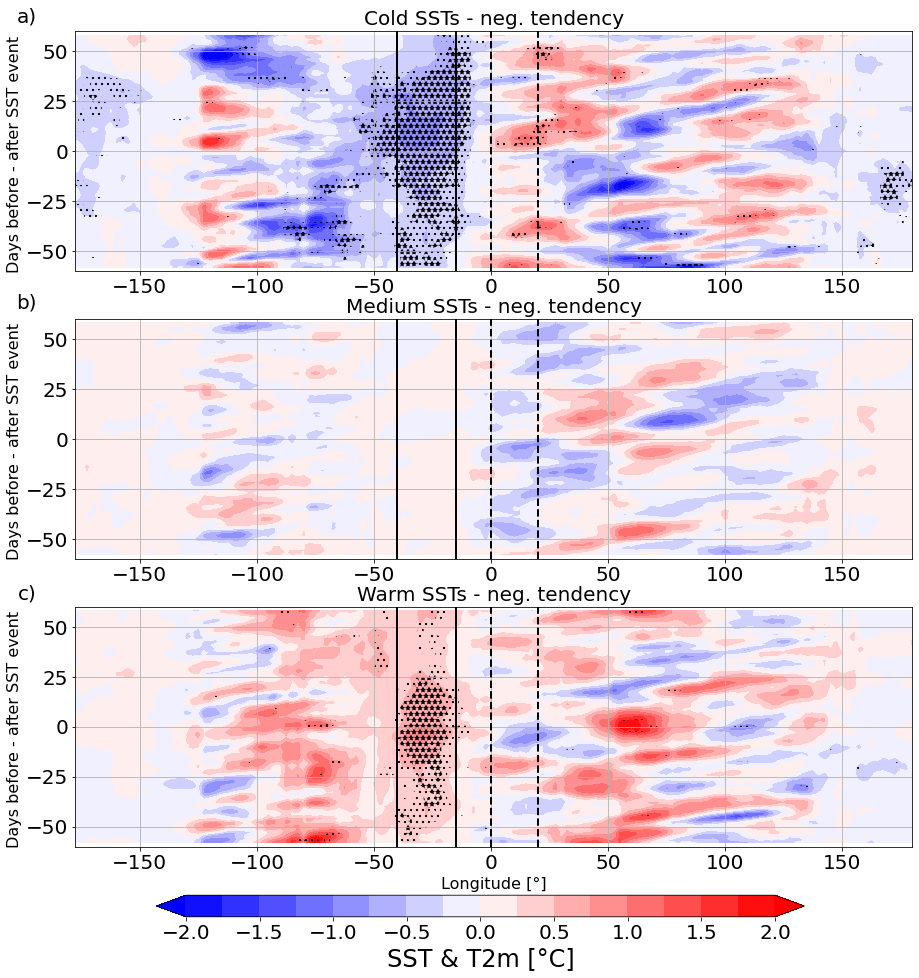

In [52]:
ds_lon_lead_sst_t2m = [wrapTo180(v_lon_lead['sst_t2m'][0],v_lon_lead['sst_t2m'][0].lon), wrapTo180(v_lon_lead['z300'][0],v_lon_lead_prob_pos['z300'][0].lon)]
ds_lon_lead_sst_t2m_prob_pos = [wrapTo180(1- v_lon_lead_prob_pos['sst_t2m'][0],v_lon_lead_prob_pos['sst_t2m'][0].lon), wrapTo180(v_lon_lead_prob_pos['sst_t2m'][0],v_lon_lead_prob_pos['sst_t2m'][0].lon)]

#ds_sst_t2m_welch_rm = [wrapTo180(v_lon_lead_welch[0],sst_t2m_lon_lead_welch[0].lon), wrapTo180(sst_t2m_lon_lead_welch[1], sst_t2m_lon_lead_welch[1].lon)]

##### Plot 
fig = plt.figure(figsize=(15,15))
titles=['Cold SSTs - neg. tendency', 'Medium SSTs - neg. tendency', 'Warm SSTs - neg. tendency']
y_len=[0.745,0.59, 0.435, 0.275, 0.12]
levels=np.linspace(-2,2,17)
j=[0,2,3]
axs=[]
for i in range(1,4):
    axs.append(fig.add_subplot(3,1,i))

for i in range(0,3):
    ds = wrapTo180(v_lon_lead['sst_t2m'][j[i]], v_lon_lead['sst_t2m'][j[i]].lon)
    ds_prob_pos = wrapTo180(v_lon_lead_prob_pos['sst_t2m'][j[i]], v_lon_lead_prob_pos['sst_t2m'][j[i]].lon)
    contf= axs[i].contourf(ds.lon, v_lon_lead['sst_t2m'][j[i]].lead_lag,ds, cmap='bwr', levels=levels, extend ='both')
    #cont= axs[i].contour(ds_shf_rm[i].lon, ds_shf_rm[i].lead_lag,ds_shf_rm[i], colors='black')
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos > 0.9),1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos < 0.1),1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos > 0.8),1, hatches=['','..'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos < 0.2),1, hatches=['','..'], alpha=0)

    #axs[i].clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    if i==2:
        axs[i].set_xlabel('Longitude [°]', fontsize=16)
    axs[i].plot([-40,-40],[-60,60], color='black', ls='-', lw=2)
    axs[i].plot([-15,-15],[-60,60], color='black', ls='-', lw=2)
    axs[i].plot([0,0],[-60,60], color='black', ls='--', lw=2)
    axs[i].plot([20,20],[-60,60], color='black', ls='--', lw=2)
    axs[i].set_ylabel('Days before - after SST event ', fontsize=16)
    axs[i].set_ylim([-60,60])
    axs[i].set_title(titles[i], fontsize=20)
    axs[i].grid()
    #cb_ax = fig.add_axes([0.91, y_len[i], 0.015, 0.14])
    #cb = plt.colorbar(contf, cax=cb_ax)
    #cb.set_label(label='SST & T2m [°C]', size='large')
    
plt.figtext(0.08,0.9025,"a)", ha="center", va="top", fontsize=20)
plt.figtext(0.08,0.6375,"b)", ha="center", va="top", fontsize=20)
plt.figtext(0.08,0.3675,"c)", ha="center", va="top", fontsize=20)

cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='SST & T2m [°C]', size='large')
rasterize_list = [axs[0], axs[1]]
raster.rasterize_and_save('ERA5_SST_T2M_composites_tendencies_lead_lag_lat_Hovmoller_detrended_1979_2019_3consec_days_5drm.pdf', rasterize_list, dpi=300)


### Plot lat vs lead/lag contourf plots

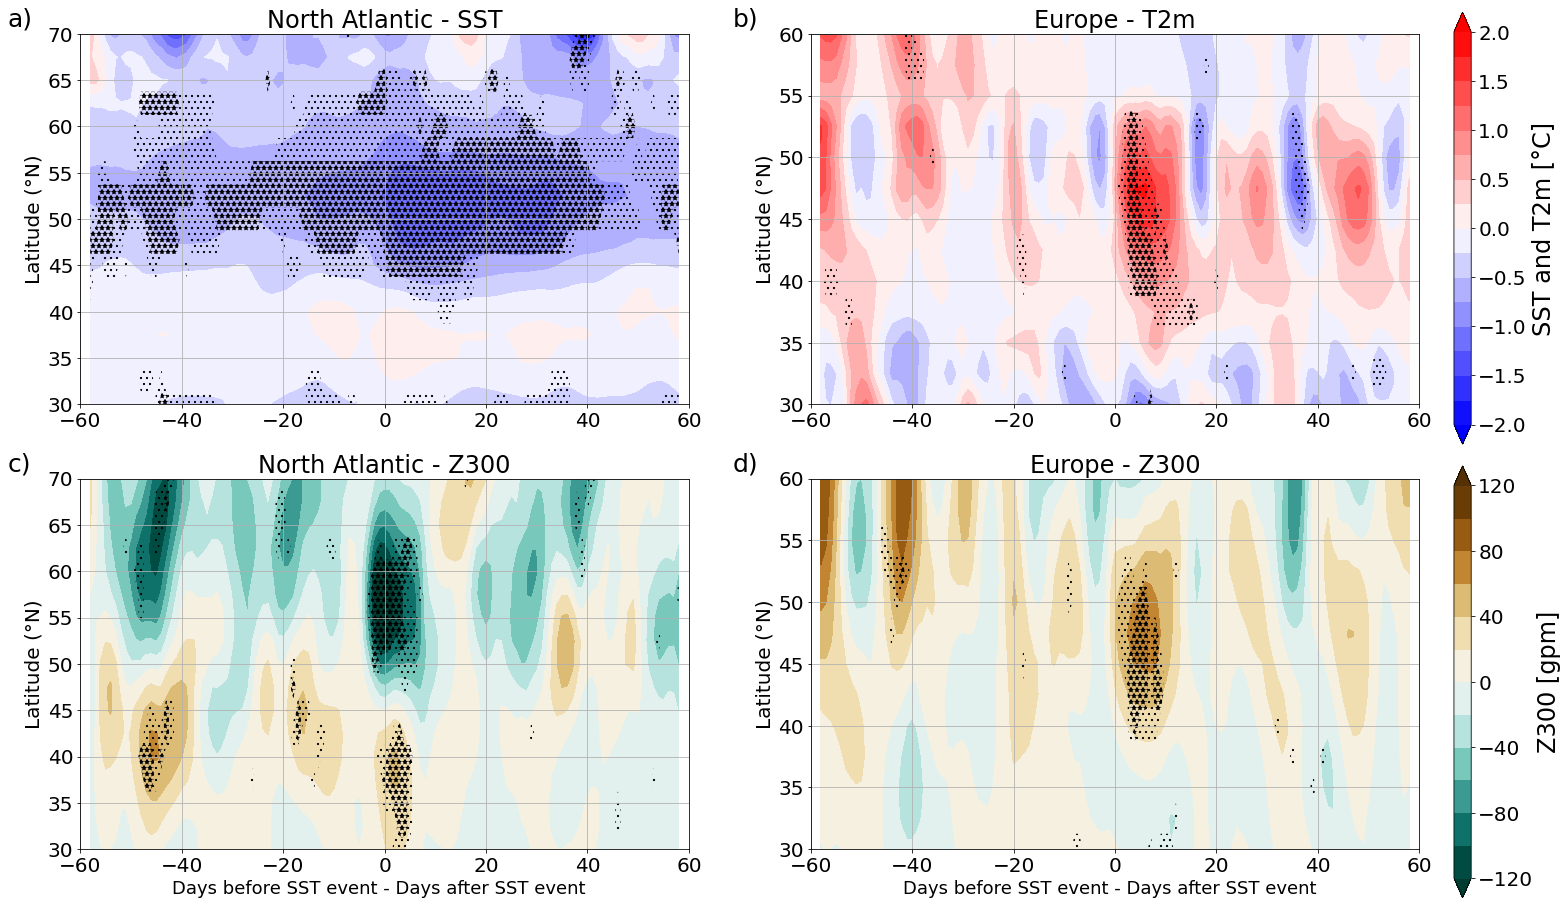

In [53]:
ds_lat_lead= [v_Atl_lat_lead['sst_t2m'][0],v_Euro_lat_lead['sst_t2m'][0], v_Atl_lat_lead['z300'][0], v_Euro_lat_lead['z300'][0]]
ds_lat_lead_pos= [v_Atl_lat_lead_prob_pos['sst_t2m'][0], v_Euro_lat_lead_prob_pos['sst_t2m'][0], v_Atl_lat_lead_prob_pos['z300'][0], v_Euro_lat_lead_prob_pos['z300'][0]]

#ds_z_welch_lat_lead= [z_Atl_lat_lead_welch[0],z_Euro_lat_lead_welch[0], z_Atl_lat_lead_welch[1], z_Euro_lat_lead_welch[1]]

fig = plt.figure(figsize=(24,15))
titles=['North Atlantic - SST','Europe - T2m',  'North Atlantic - Z300', 'Europe - Z300']
levels=[np.linspace(-2,2,17), np.linspace(-2,2,17), np.linspace(-120,120,13), np.linspace(-120,120,13)]
clevels_max=np.linspace(0.9,1.0,2)
cmaps= ['bwr','bwr',BrBG_cmap, BrBG_cmap]
axs=[]
for i in range(1,5):
    axs.append(fig.add_subplot(2,2,i))
for i in range(0,4):
    if i==0:
        contf= axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat, ds_lat_lead[i].transpose(), cmap=cmaps[i], levels=levels[i], extend='both')
    else:
        contf_z300= axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat, ds_lat_lead[i].transpose(), cmap=cmaps[i], levels=levels[i], extend='both')
    #cont=axs[i].contour(sst_t2m_Atl_lat_lead[0].lead_lag, sst_t2m_Atl_lat_lead[0].lat, ds_sst_t2m_lat_lead[i].transpose(), colors='black', levels=clevels, linestyles='--')
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=15)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() > 0.9,1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() < 0.1,1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() > 0.8,1, hatches=['','..'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() < 0.2,1, hatches=['','..'], alpha=0)
    #cont=axs[i].contour(ds_lat_lead_pos[i].lead_lag, ds_lat_lead_pos[i].lat, ds_lat_lead_pos[i].transpose(), colors='black', levels=clevels_max, linewidths=3)
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=20)
    #cont=axs[i].contour(ds_lat_lead_pos[i].lead_lag, ds_lat_lead_pos[i].lat, 1 - ds_lat_lead_pos[i].transpose(), colors='black',linestyle='--', levels=clevels_max, linewidths=3)
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=20)
    if i>1:
        axs[i].set_xlabel('Days before SST event - Days after SST event  ', fontsize=18)
    axs[i].set_ylabel('Latitude (°N)')
    axs[i].set_title(titles[i])
    axs[i].set_ylim([30,70])
    axs[1].set_ylim([30,60])
    axs[3].set_ylim([30,60])
    axs[i].set_xlim([-60,60])
    axs[i].grid()
plt.figtext(0.09,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.09,0.4925,"c)", ha="center", va="top", fontsize=25)
plt.figtext(0.51,0.905,"b)", ha="center", va="top", fontsize=25)
plt.figtext(0.51,0.4925,"d)", ha="center", va="top", fontsize=25)

cb_ax = fig.add_axes([0.92, 0.08, 0.01, 0.4])
cb = fig.colorbar(contf_z300, cax=cb_ax, orientation='vertical')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='Z300 [gpm]', size='large')

cb_ax = fig.add_axes([0.92, 0.50, 0.01, 0.4])
cb = fig.colorbar(contf, cax=cb_ax, orientation='vertical')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='SST and T2m [°C]', size='large')
rasterize_list = [axs[0], axs[1], axs[2],axs[3]]
raster.rasterize_and_save('ERA5_Z300_SST_T2M_composite_lead_lag_lat_detrended_1979_2019_3consec_days_5drm.pdf', rasterize_list, dpi=300)

## All parameters together on maps with -5,0,+5,+10 days: absolute values

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


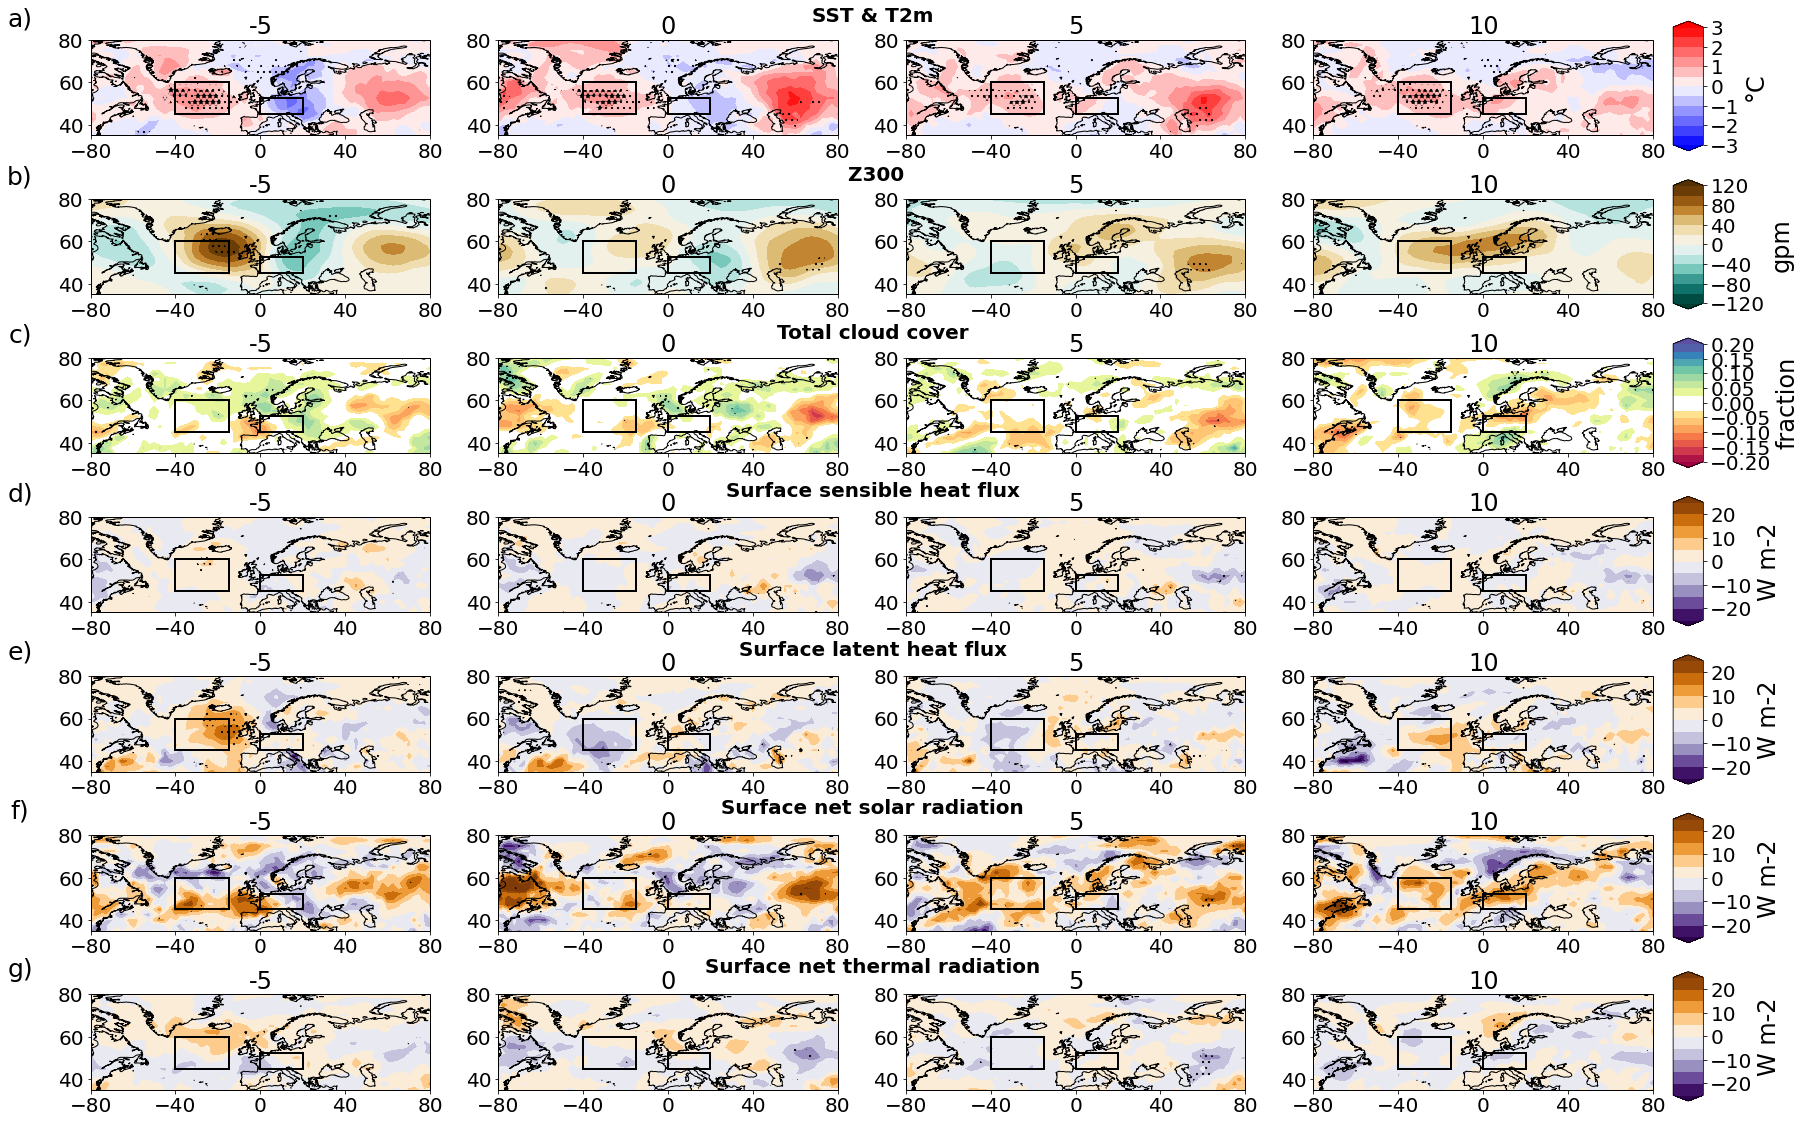

In [13]:
# Make maps before, during and after SST event for different variables:
triple_lag = [-5,0,5,10]
fig = plt.figure(figsize=(28,20))
axs=[]
for i in range(1,29):
        axs.append(fig.add_subplot(7,4,i, projection=prj))
var_map_set = [v_map['sst_t2m'], v_map['z300'], v_map['tcc'],v_map['shf'], v_map['lhf'], v_map['snsr'], v_map['sntr']]
#welch_map_set=[sst_t2m_map_welch, z_map_welch, tcc_map_welch, shf_map_welch,  lhf_map_welch, snsr_map_welch, sntr_map_welch]
prob_pos_map_set=[v_map_prob_pos['sst_t2m'], v_map_prob_pos['z300'], v_map_prob_pos['tcc'],v_map_prob_pos['shf'], v_map_prob_pos['lhf'], v_map_prob_pos['snsr'], v_map_prob_pos['sntr']]
var_lag_set = ['-5','0','5','10']
Unit=['°C','gpm','fraction','W m-2','W m-2','W m-2','W m-2']

cmap=['bwr',BrBG_cmap,spectral_white_cm,PuOr_cmap,PuOr_cmap,PuOr_cmap,PuOr_cmap]
y_len=[0.79, 0.68, 0.57,0.46,0.35,0.24, 0.13]
levels= [np.linspace(-3,3,13),np.linspace(-120,120,13),np.linspace(-0.2,0.2,17),np.linspace(-25,25,11),np.linspace(-25,25,11),np.linspace(-25,25,11),np.linspace(-25,25,11)]
k=0
for j in range(0,7):
    for i in range(0,4):
        contf= axs[k].contourf(X,Y,np.c_[var_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), var_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]], cmap=cmap[j], levels=levels[j], extend='both')
        axs[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
        #axs[k].contourf(X, Y,np.c_[welch_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),welch_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < low_p_val,1, hatches=['','..'], alpha=0)
        #axs[i].contourf(X, Y,np.c_[welch_map_set[j][0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),welch_map_set[j][0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < upp_p_val,1, hatches=['','..'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] > 0.9,1, hatches=['','**'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < 0.1,1, hatches=['','**'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] > 0.8,1, hatches=['','..'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j][3].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < 0.2,1, hatches=['','..'], alpha=0)

        axs[k].set_title(var_lag_set[i])
        k=k+1
        if i==3:
            cb_ax = fig.add_axes([0.91, y_len[j], 0.015, 0.09])
            cb = plt.colorbar(contf, cax=cb_ax)
            cb.set_label(label=Unit[j], size='large')

for ax in axs:
    ax.coastlines('50m')
    #ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    #ax.text(0.5, -0.3, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    #ax.gridlines()
    ax.set_extent([-80, 80, 35, 80], prj)
    ax.set_xticks([-80, -40,0, 40, 80],crs=prj)
    ax.set_yticks([40, 60, 80],crs=prj)

var_name = ["SST & T2m"," Z300" ,"Total cloud cover", "Surface sensible heat flux", "Surface latent heat flux", "Surface net solar radiation", "Surface net thermal radiation"]
lab= ["a)","b)", "c)", "d)", "e)", "f)", "g)"]
y = [0.89, 0.78, 0.67, 0.56, 0.45, 0.34, 0.23]
for i in range(7):
    plt.figtext(0.09,y[i],lab[i], ha="center", va="top", fontsize=25)
    plt.figtext(0.513,y[i],var_name[i], ha="center", va="top", fontsize=20, weight='bold')
    
rasterize_list = [axs[0], axs[1], axs[2],axs[3],axs[4],axs[5],axs[6],axs[7],axs[8],axs[9],axs[10],axs[11],axs[12],axs[13],axs[14],axs[15],axs[16],axs[17],axs[18],axs[19],axs[20],axs[21],axs[22],axs[23],axs[24],axs[25],axs[26],axs[27]]
raster.rasterize_and_save('ERA5_warm_neg_tend_composite_1979_2019_different_params_maps_Atl_abs_values_7_4_prob_3consec_days_5drm.pdf', rasterize_list, dpi=300)

## Maps for vertical velocities, temperature at 300hPa, total precipitation and cloud cover types

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


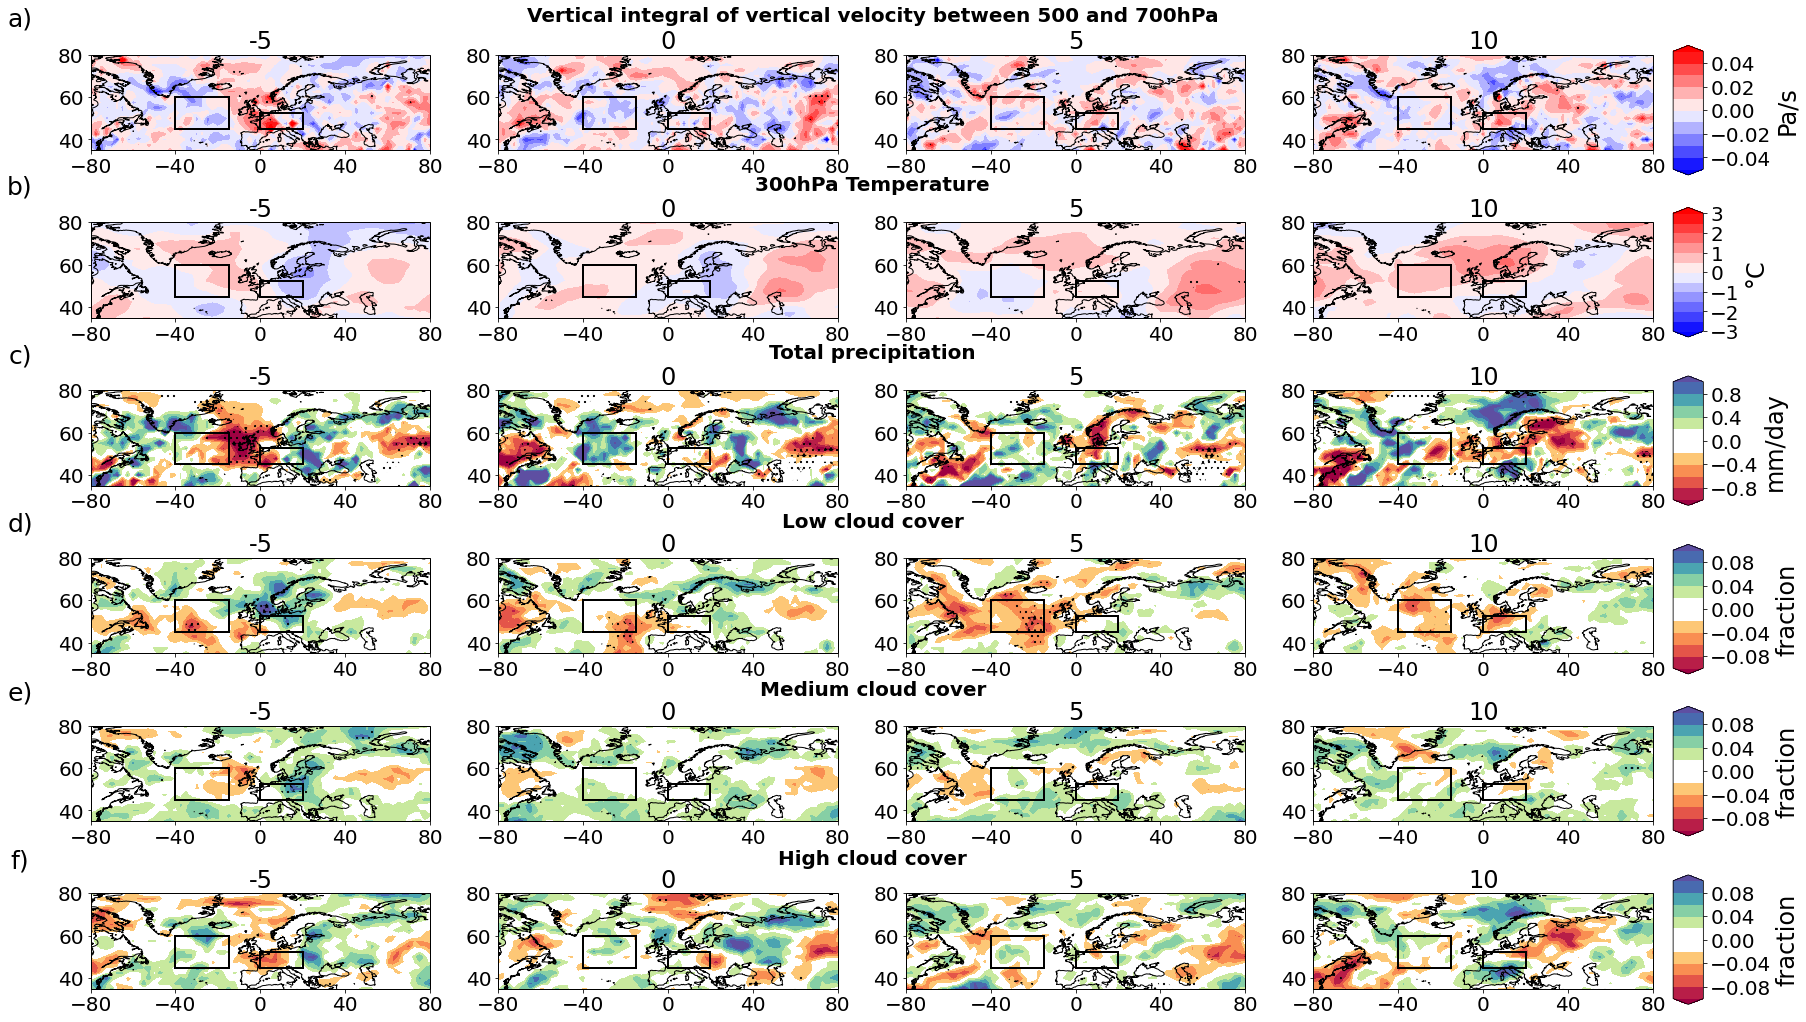

In [17]:
fig = plt.figure(figsize=(28,18))
axs=[]
l=3
for i in range(1,25):
        axs.append(fig.add_subplot(6,4,i, projection=prj))
var_map_set = [v_map['vv_700_500'][l],v_map['t300'][l], v_map['tp'][l],v_map['lcc'][l], v_map['mcc'][l], v_map['hcc'][l]]
#welch_map_set = [vv700_500_map_welch[0],t300_map_welch[0], lsp_map_welch[0],lcc_map_welch[0], mcc_map_welch[0], hcc_map_welch[0]]
prob_pos_map_set = [v_map_prob_pos['vv_700_500'][l],v_map_prob_pos['t300'][l], v_map_prob_pos['tp'][l],v_map_prob_pos['lcc'][l], v_map_prob_pos['mcc'][l], v_map_prob_pos['hcc'][l]]

Unit=['Pa/s','°C','mm/day','fraction','fraction','fraction']

cmap=['bwr','bwr', spectral_white_cm, spectral_white_cm, spectral_white_cm, spectral_white_cm]
levels= [np.linspace(-0.05,0.05,11), np.linspace(-3,3,13), np.linspace(-1,1,11), np.linspace(-0.1,0.1,11), np.linspace(-0.1,0.1,11), np.linspace(-0.1,0.1,11)]
y_len=[0.77,0.645, 0.515, 0.385, 0.26,0.13]
k=0
for j in range(0,6):
    for i in range(0,4):
        contf= axs[k].contourf(X,Y,np.c_[var_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), var_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]], cmap=cmap[j], transform=prj, levels=levels[j], extend='both')
        axs[k].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
#        axs[k].contourf(X, Y,np.c_[welch_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),welch_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < low_p_val,1, hatches=['','..'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] > 0.9,1, hatches=['','**'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < 0.1,1, hatches=['','**'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] > 0.8,1, hatches=['','..'], alpha=0)
        axs[k].contourf(X, Y,np.c_[prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),prob_pos_map_set[j].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < 0.2,1, hatches=['','..'], alpha=0)

        #axs[i].contourf(X, Y,np.c_[welch_map_set[j][0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(),welch_map_set[j][0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]] < upp_p_val,1, hatches=['','..'], alpha=0)
        axs[k].set_title(var_lag_set[i])
        #if j==1:
            #quiv = axs[k].quiver(X,Y,np.c_[u300_map[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), u300_map[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]], np.c_[v300_map[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), v300_map[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]], transform=prj)
            #axs[k].quiver(X,Y,[np.c_[u300_map_welch[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), u300_map_welch[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]], np.c_[v300_map_welch[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze(), v300_map_welch[0].sel(lead_lag=slice(triple_lag[i],triple_lag[i])).squeeze()[:,0]]] < low_p_val, transform=prj, width=2)

        k=k+1
        if i==3:
            cb_ax = fig.add_axes([0.91, y_len[j], 0.015, 0.10])
            cb = plt.colorbar(contf, cax=cb_ax)
            cb.set_label(label=Unit[j], size='large')


for ax in axs:
    ax.coastlines('50m')
    #ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    #ax.text(0.5, -0.3, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
    #ax.gridlines()
    ax.set_extent([-80, 80, 35, 80], crs=prj)
    ax.set_xticks([-80, -40,0, 40, 80],crs=prj)
    ax.set_yticks([40, 60, 80],crs=prj)

#cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
#cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
#cb.ax.tick_params(labelsize=20)
#cb.set_label(label='gpm', size='large', weight='bold')

var_name = ["Vertical integral of vertical velocity between 500 and 700hPa" ,"300hPa Temperature", "Total precipitation", "Low cloud cover", "Medium cloud cover", "High cloud cover"]
y = [0.90, 0.77, 0.64, 0.51, 0.38, 0.25]
for i in range(6):
    plt.figtext(0.513,y[i],var_name[i], ha="center", va="top", fontsize=20, weight='bold')
    plt.figtext(0.09,y[i],lab[i], ha="center", va="top", fontsize=25)

rasterize_list = [axs[0], axs[1], axs[2],axs[3],axs[4],axs[5],axs[6],axs[7],axs[8],axs[9],axs[10],axs[11],axs[12],axs[13],axs[14],axs[15],axs[16],axs[17],axs[18],axs[19],axs[20],axs[21],axs[22],axs[23]]
raster.rasterize_and_save('ERA5_warm_neg_tend_composite_1979_2019_vv500_700_t300_TP_Cloud_cover_types_maps_Atl_abs_values_prob_3consec_days_5drm.pdf', rasterize_list, dpi=300)

### Plot lead/lag vs lon contourf plots: Z300 - PW & RWP - ANOMALIES

In [ ]:
ds_z_rm = [v_map['z300'][0], wrapTo180(v_lon_lead['z300'][0],v_lon_lead['z300'][0].lon),wrapTo180(v_lon_lead['z_PW'][0],v_lon_lead['z_PW'][0].lon),wrapTo180(v_lon_lead['z_RWP'][0],v_lon_lead['z_RWP'][0].lon)]
#ds_z_welch_rm = [z_map_welch[0], wrapTo180(z_lon_lead_welch[0],z_lon_lead_welch[0].lon),wrapTo180(z_PW_lon_lead_welch[0],z_PW_lon_lead_welch[0].lon),wrapTo180(z_RWP_lon_lead_welch[0],z_RWP_lon_lead_welch[0].lon)]
ds_z_prob_pos_rm = [v_map_prob_pos['z300'][0], wrapTo180(v_lon_lead_prob_pos['z300'][0],v_lon_lead_prob_pos['z300'][0].lon),wrapTo180(v_lon_lead_prob_pos['z_PW'][0],v_lon_lead_prob_pos['z_PW'][0].lon),wrapTo180(v_lon_lead_prob_pos['z_RWP'][0],v_lon_lead_prob_pos['z_RWP'][0].lon)]

##### Plot 
fig = plt.figure(figsize=(24,20))
titles=['Z300 5 days after SST event onset (+5)',' Z300','Z300 - PW','Z300 - RWP']
levels=np.linspace(-80,80,17)
axs=[]
for i in range(1,5):
    if i==1:
        axs.append(fig.add_subplot(4,1,i, projection=prj))
    else:
        axs.append(fig.add_subplot(4,1,i))
print(ds_z_rm[0].sel(lead_lag=slice(5,5)).squeeze())
for i in range(0,4):
    if i==0:
        contf= axs[i].contourf(X,Y,np.c_[ds_z_rm[i].sel(lead_lag=slice(5,5)).squeeze(), ds_z_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]], cmap=BrBG_cmap, transform=prj, levels=levels, extend='both')
        #axs[i].contourf(X, Y,(np.c_[ds_z_welch_rm[i].sel(lead_lag=slice(5,5)).squeeze(), ds_z_welch_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] < low_p_val),1, hatches=['','**'], alpha=0, transform=prj)
        #axs[i].contourf(X, Y,(np.c_[ds_z_welch_rm[i].sel(lead_lag=slice(5,5)).squeeze(), ds_z_welch_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] < upp_p_val),1, hatches=['','..'], alpha=0, transform=prj)

        axs[i].contourf(X, Y,np.c_[ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze(),ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] > 0.9,1, hatches=['','**'], alpha=0)
        axs[i].contourf(X, Y,np.c_[ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze(),ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] < 0.1,1, hatches=['','**'], alpha=0)
        axs[i].contourf(X, Y,np.c_[ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze(),ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] > 0.8,1, hatches=['','..'], alpha=0)
        axs[i].contourf(X, Y,np.c_[ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze(),ds_z_prob_pos_rm[i].sel(lead_lag=slice(5,5)).squeeze()[:,0]] < 0.2,1, hatches=['','..'], alpha=0)
        axs[i].plot([-40,-40],[40,60], color='black', ls='-', lw=2)
        axs[i].plot([-15,-15],[40,60], color='black', ls='-', lw=2)
        axs[i].plot([0,0],[40,60], color='black', ls='--', lw=2)
        axs[i].plot([20,20],[40,60], color='black', ls='--', lw=2)
        axs[i].plot([-180,180],[60,60], color='black', ls='-', lw=3)
        axs[i].plot([-180,180],[40,40], color='black', ls='-', lw=3)
        axs[i].set_ylabel('Latitude [°N]')
        axs[i].set_yticks([20,40, 60,80], prj)
    else:
        contf= axs[i].contourf(ds_z_rm[i].lon, ds_z_rm[i].lead_lag,ds_z_rm[i], cmap=BrBG_cmap, levels=levels, extend='both')
#        axs[i].contourf(ds_z_rm[i].lon, ds_z_rm[i].lead_lag,(ds_z_welch_rm[i] < low_p_val),1, hatches=['','**'], alpha=0)
#        axs[i].contourf(ds_z_rm[i].lon, ds_z_rm[i].lead_lag,(ds_z_welch_rm[i] < upp_p_val),1, hatches=['','..'], alpha=0)
        axs[i].contourf(ds_z_prob_pos_rm[i].lon, ds_z_prob_pos_rm[i].lead_lag, (ds_z_prob_pos_rm[i] > 0.9),1, hatches=['','**'], alpha=0)
        axs[i].contourf(ds_z_prob_pos_rm[i].lon, ds_z_prob_pos_rm[i].lead_lag, (ds_z_prob_pos_rm[i] < 0.1),1, hatches=['','**'], alpha=0)
        axs[i].contourf(ds_z_prob_pos_rm[i].lon, ds_z_prob_pos_rm[i].lead_lag, (ds_z_prob_pos_rm[i] > 0.8),1, hatches=['','..'], alpha=0)
        axs[i].contourf(ds_z_prob_pos_rm[i].lon, ds_z_prob_pos_rm[i].lead_lag, (ds_z_prob_pos_rm[i] < 0.2),1, hatches=['','..'], alpha=0)
        #axs[-2].set_xlabel('Longitude')
        axs[i].plot([-40,-40],[-60,60], color='black', ls='-', lw=2)
        axs[i].plot([-15,-15],[-60,60], color='black', ls='-', lw=2)
        axs[i].plot([0,0],[-60,60], color='black', ls='--', lw=2)
        axs[i].plot([20,20],[-60,60], color='black', ls='--', lw=2)
        axs[i].set_ylabel('Days before - after SST event', fontsize=15)
        axs[i].set_yticks([-45,-30,-15,0,15,30,45])
    axs[i].set_title(titles[i], fontsize=22)
    axs[i].grid()
    axs[i].set_ylim([-30,30])
    axs[i].set_xticks([-180, -120, -60, 0, 60, 120, 180])
    axs[-1].set_xlabel('Longitude [°]')
        
axs[0].coastlines('50m', lw=2)
axs[0].set_extent([-180, 180, 20, 80], prj)

    
plt.figtext(0.09,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.09,0.71,"b)", ha="center", va="top", fontsize=25)
plt.figtext(0.09,0.505,"c)", ha="center", va="top", fontsize=25)
plt.figtext(0.09,0.31,"d)", ha="center", va="top", fontsize=25)
#plt.figtext(0.51,0.64,"d)", ha="center", va="top", fontsize=25)
#plt.figtext(0.51,0.375,"f)", ha="center", va="top", fontsize=25)

cb_ax = fig.add_axes([0.214, 0.05, 0.6, 0.02])
cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='gpm', size='large')

rasterize_list = [axs[0], axs[1], axs[2],axs[3]]
raster.rasterize_and_save('ERA5_Z300_SST_T2M_composite_lead_lag_lat_Hovmoller_rm_detrended_1979_2019_Map_PW_RWP_3consec_days_5drm.pdf', rasterize_list, dpi=300)

# Supplement 

### SST/T2M anomalies (coloured and Z300 anomalies (contours) based on ALL COLD SST composites

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is depreca

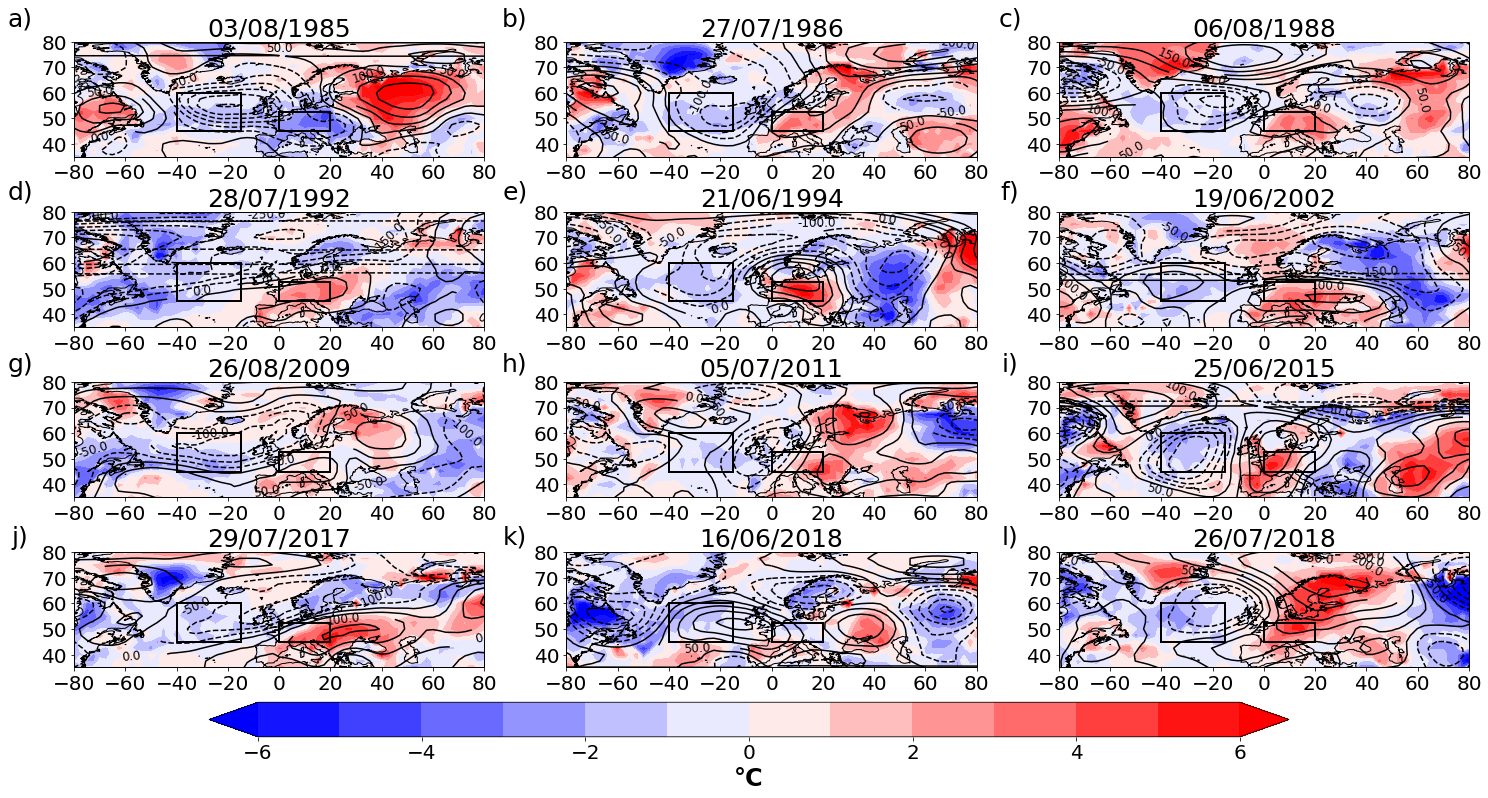

In [57]:
# Set general font size
plt.rcParams['font.size'] = '20'

##### Show Atlantic boxes
x1, y1 = [-40, -15], [45, 45]
x2, y2 = [-40, -15], [60, 60]
x3, y3 = [-40, -40], [45, 60]
x4, y4 = [-15, -15], [45, 60]

# Show T2M boxes
x1_E, y1_E = [0, 20], [45, 45]
x2_E, y2_E = [0, 20], [52.5, 52.5]
x3_E, y3_E = [0, 0], [45, 52.5]
x4_E, y4_E = [20, 20], [45, 52.5]

sst_t2m_map_wtm_lag5 = v_map_wtm['sst_t2m'][0].sel(lead_lag=slice(5,5)).squeeze()
z_map_wtm_lag5 = v_map_wtm['z300'][0].sel(lead_lag=slice(5,5)).squeeze()

dy=[105,115,105,90,115,80,90,105,80,80,90,105]
dates_t2m =sst_t2m_map_wtm_lag5.time.dt.strftime("%d/%m/%Y")

levels = np.linspace(-6.0,6.0,13)
clevels = np.linspace(-300,300,13)

fig = plt.figure(figsize=(25,12))
lon=np.linspace(0,360,145)
X, Y = np.meshgrid(lon, ds_ERA5_z.lat)
prj = ccrs.PlateCarree()
axs=[]
for i in range(1,13):
    axs.append(fig.add_subplot(4,3,i, projection=prj))

for i in range(0,12):
   # if i==0:
   #     axs[0].contourf(X,Y,np.c_[v_map['sst_t2m'][0].sel(lead_lag=slice(5,5)).squeeze(),v_map['sst_t2m'][0].sel(lead_lag=slice(5,5)).squeeze()[:,0]], cmap='bwr', transform=prj, levels=levels, rasterized=True)
   #     cont = axs[0].contour(X,Y,np.c_[v_map['z300'][0].sel(lead_lag=slice(5,5)).squeeze(),v_map['z300'][0].sel(lead_lag=slice(5,5)).squeeze()[:,0]], colors='black', levels=clevels, rasterized=True)
   #     axs[0].set_title('Composite mean', size=25)
   #     axs[0].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
   #     axs[0].clabel(cont, inline=True, fmt='%1.1f', fontsize=12)

   # else: 
        contf= axs[i].contourf(X,Y,np.c_[sst_t2m_map_wtm_lag5[i,:,:].squeeze(),sst_t2m_map_wtm_lag5[i,:,:].squeeze()[:,0]], cmap='bwr', transform=prj, levels=levels, extend='both', rasterized=True)
        cont = axs[i].contour(X,Y,np.c_[z_map_wtm_lag5[i,:,:].squeeze(),z_map_wtm_lag5[i,:,:].squeeze()[:,0]], colors='black', levels=clevels, extend='both', rasterized=True)
        axs[i].set_title(dates_t2m.values[i], size=25)
        axs[i].plot(x1, y1, x2, y2,x3,y3,x4,y4,x1_E, y1_E, x2_E, y2_E,x3_E,y3_E,x4_E,y4_E, color='black', linestyle='-', linewidth=2)
        axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=12)


for ax in axs:
        ax.coastlines('50m')
        #ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
        #ax.text(0.5, -0.22, 'Longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', fontsize =20, transform=ax.transAxes)
        #ax.gridlines()
        ax.set_extent([-80, 80, 35, 80], prj)
        ax.set_xticks([-80, -60, -40, -20,0,20, 40, 60, 80],crs=prj)
        ax.set_yticks([40, 50, 60, 70,80],crs=prj)

plt.figtext(0.095,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.37,0.905,"b)", ha="center", va="top", fontsize=25)
plt.figtext(0.645,0.905,"c)", ha="center", va="top", fontsize=25)
plt.figtext(0.095,0.705,"d)", ha="center", va="top", fontsize=25)
plt.figtext(0.37,0.705,"e)", ha="center", va="top", fontsize=25)
plt.figtext(0.645,0.705,"f)", ha="center", va="top", fontsize=25)
plt.figtext(0.095,0.505,"g)", ha="center", va="top", fontsize=25)
plt.figtext(0.37,0.505,"h)", ha="center", va="top", fontsize=25)
plt.figtext(0.645,0.505,"i)", ha="center", va="top", fontsize=25)
plt.figtext(0.095,0.305,"j)", ha="center", va="top", fontsize=25)
plt.figtext(0.37,0.305,"k)", ha="center", va="top", fontsize=25)
plt.figtext(0.645,0.305,"l)", ha="center", va="top", fontsize=25)

cb_ax = fig.add_axes([0.2, 0.06, 0.6, 0.04])
cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='°C', size='large', weight='bold')
rasterize_list = [axs[0], axs[1], axs[2],axs[3],axs[4],axs[5],axs[6],axs[7],axs[8],axs[9],axs[10],axs[11]]
raster.rasterize_and_save('ERA5_cold_composite_maps_each_case.pdf', rasterize_list, dpi=300)
#plt.savefig('ERA5_cold_composite_maps_each_case.pdf')

### Plot lead/lag vs lon contourf plots: SST&T2M of events with positive tendencies

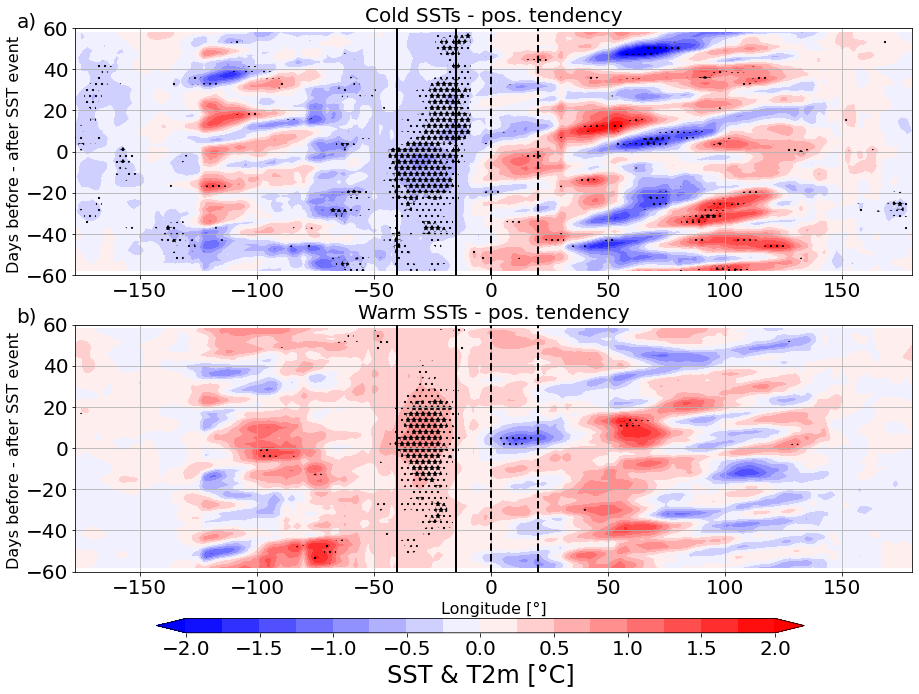

In [58]:
ds_lon_lead_sst_t2m = [wrapTo180(v_lon_lead['sst_t2m'][0],v_lon_lead['sst_t2m'][0].lon), wrapTo180(v_lon_lead['z300'][0],v_lon_lead_prob_pos['z300'][0].lon)]
ds_lon_lead_sst_t2m_prob_pos = [wrapTo180(1- v_lon_lead_prob_pos['sst_t2m'][0],v_lon_lead_prob_pos['sst_t2m'][0].lon), wrapTo180(v_lon_lead_prob_pos['sst_t2m'][0],v_lon_lead_prob_pos['sst_t2m'][0].lon)]

#ds_sst_t2m_welch_rm = [wrapTo180(v_lon_lead_welch[0],sst_t2m_lon_lead_welch[0].lon), wrapTo180(sst_t2m_lon_lead_welch[1], sst_t2m_lon_lead_welch[1].lon)]

##### Plot 
fig = plt.figure(figsize=(15,10))
titles=['Cold SSTs - pos. tendency', 'Warm SSTs - pos. tendency']
y_len=[0.745,0.59, 0.435, 0.275, 0.12]
levels=np.linspace(-2,2,17)
j=[1,4]
axs=[]
for i in range(1,3):
    axs.append(fig.add_subplot(2,1,i))

for i in range(0,2):
    ds = wrapTo180(v_lon_lead['sst_t2m'][j[i]], v_lon_lead['sst_t2m'][j[i]].lon)
    ds_prob_pos = wrapTo180(v_lon_lead_prob_pos['sst_t2m'][j[i]], v_lon_lead_prob_pos['sst_t2m'][j[i]].lon)
    contf= axs[i].contourf(ds.lon, v_lon_lead['sst_t2m'][j[i]].lead_lag,ds, cmap='bwr', levels=levels, extend ='both')
    #cont= axs[i].contour(ds_shf_rm[i].lon, ds_shf_rm[i].lead_lag,ds_shf_rm[i], colors='black')
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos > 0.9),1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos < 0.1),1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos > 0.8),1, hatches=['','..'], alpha=0)
    axs[i].contourf(ds_prob_pos.lon, ds_prob_pos.lead_lag,(ds_prob_pos < 0.2),1, hatches=['','..'], alpha=0)

    #axs[i].clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    if i==1:
        axs[i].set_xlabel('Longitude [°]', fontsize=16)
    axs[i].plot([-40,-40],[-60,60], color='black', ls='-', lw=2)
    axs[i].plot([-15,-15],[-60,60], color='black', ls='-', lw=2)
    axs[i].plot([0,0],[-60,60], color='black', ls='--', lw=2)
    axs[i].plot([20,20],[-60,60], color='black', ls='--', lw=2)
    axs[i].set_ylabel('Days before - after SST event ', fontsize=16)
    axs[i].set_ylim([-60,60])
    axs[i].set_title(titles[i], fontsize=20)
    axs[i].grid()
    #cb_ax = fig.add_axes([0.91, y_len[i], 0.015, 0.14])
    #cb = plt.colorbar(contf, cax=cb_ax)
    #cb.set_label(label='SST & T2m [°C]', size='large')
    
plt.figtext(0.08,0.9025,"a)", ha="center", va="top", fontsize=20)
plt.figtext(0.08,0.4925,"b)", ha="center", va="top", fontsize=20)

cb_ax = fig.add_axes([0.2, 0.04, 0.6, 0.02])
cb = fig.colorbar(contf, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='SST & T2m [°C]', size='large')
rasterize_list = [axs[0], axs[1]]
raster.rasterize_and_save('ERA5_SST_T2M_composites_pos_tendencies_lead_lag_lat_Hovmoller_detrended_1979_2019_3consec_days_5drm.pdf', rasterize_list, dpi=300)


### Plot lat vs lead/lag contourf plots

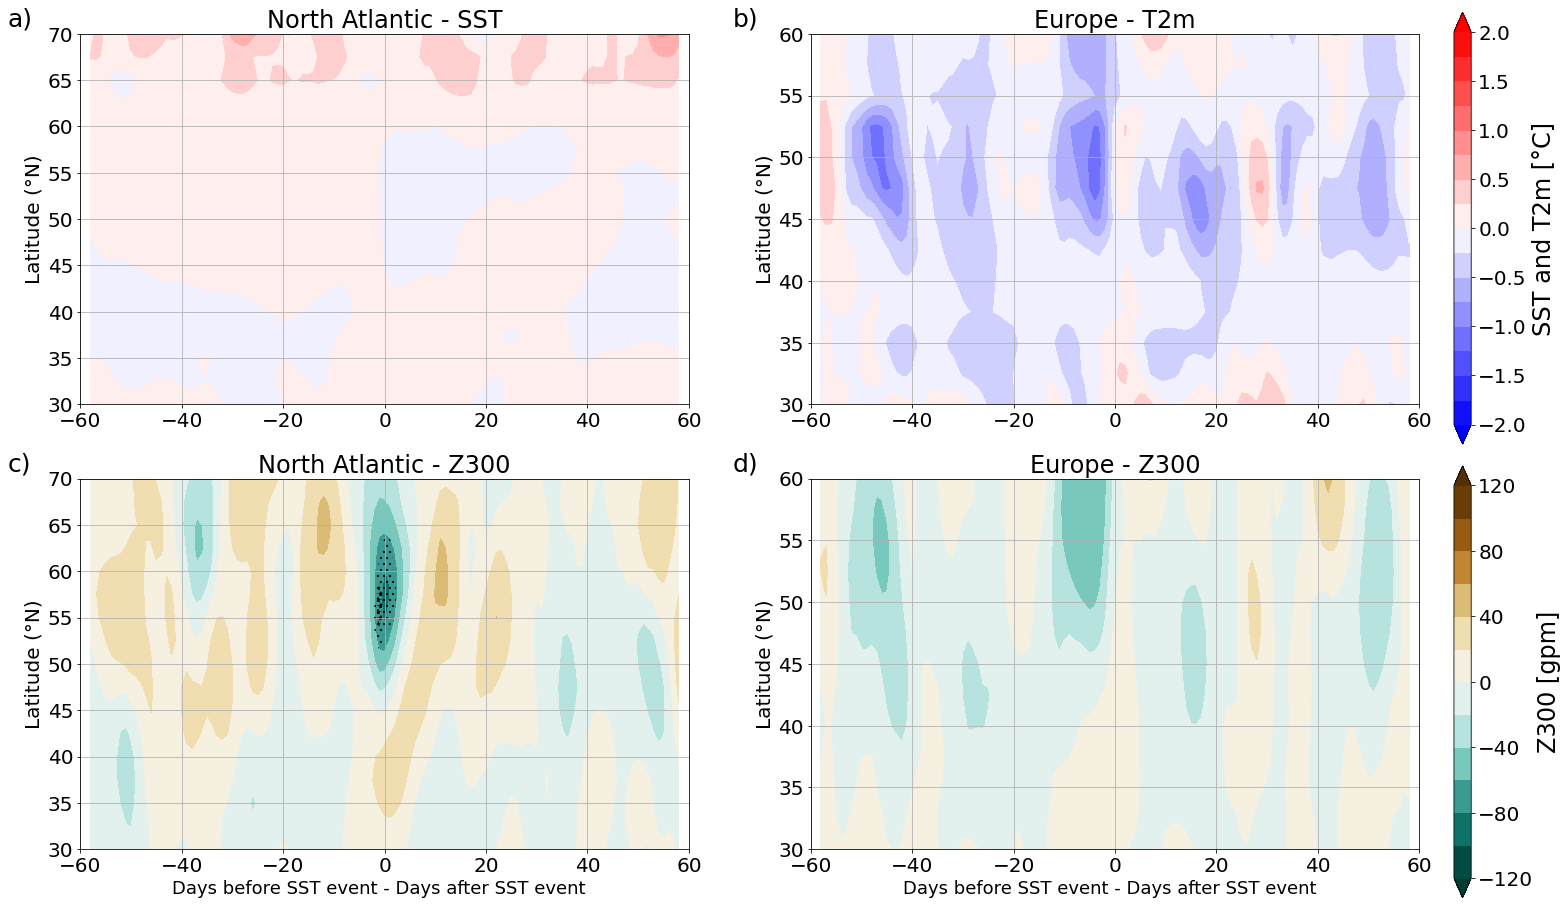

In [60]:
ds_lat_lead= [v_Atl_lat_lead['sst_t2m'][2],v_Euro_lat_lead['sst_t2m'][2], v_Atl_lat_lead['z300'][2], v_Euro_lat_lead['z300'][2]]
ds_lat_lead_pos= [v_Atl_lat_lead_prob_pos['sst_t2m'][2], v_Euro_lat_lead_prob_pos['sst_t2m'][2], v_Atl_lat_lead_prob_pos['z300'][2], v_Euro_lat_lead_prob_pos['z300'][2]]

#ds_z_welch_lat_lead= [z_Atl_lat_lead_welch[0],z_Euro_lat_lead_welch[0], z_Atl_lat_lead_welch[1], z_Euro_lat_lead_welch[1]]

fig = plt.figure(figsize=(24,15))
titles=['North Atlantic - SST','Europe - T2m',  'North Atlantic - Z300', 'Europe - Z300']
levels=[np.linspace(-2,2,17), np.linspace(-2,2,17), np.linspace(-120,120,13), np.linspace(-120,120,13)]
clevels_max=np.linspace(0.9,1.0,2)
cmaps= ['bwr','bwr',BrBG_cmap, BrBG_cmap]
axs=[]
for i in range(1,5):
    axs.append(fig.add_subplot(2,2,i))
for i in range(0,4):
    if i==0:
        contf= axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat, ds_lat_lead[i].transpose(), cmap=cmaps[i], levels=levels[i], extend='both')
    else:
        contf_z300= axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat, ds_lat_lead[i].transpose(), cmap=cmaps[i], levels=levels[i], extend='both')
    #cont=axs[i].contour(sst_t2m_Atl_lat_lead[0].lead_lag, sst_t2m_Atl_lat_lead[0].lat, ds_sst_t2m_lat_lead[i].transpose(), colors='black', levels=clevels, linestyles='--')
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=15)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() > 0.9,1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() < 0.1,1, hatches=['','**'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() > 0.8,1, hatches=['','..'], alpha=0)
    axs[i].contourf(ds_lat_lead[i].lead_lag, ds_lat_lead[i].lat,ds_lat_lead_pos[i].transpose() < 0.2,1, hatches=['','..'], alpha=0)
    #cont=axs[i].contour(ds_lat_lead_pos[i].lead_lag, ds_lat_lead_pos[i].lat, ds_lat_lead_pos[i].transpose(), colors='black', levels=clevels_max, linewidths=3)
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=20)
    #cont=axs[i].contour(ds_lat_lead_pos[i].lead_lag, ds_lat_lead_pos[i].lat, 1 - ds_lat_lead_pos[i].transpose(), colors='black',linestyle='--', levels=clevels_max, linewidths=3)
    #axs[i].clabel(cont, inline=True, fmt='%1.1f', fontsize=20)
    if i>1:
        axs[i].set_xlabel('Days before SST event - Days after SST event  ', fontsize=18)
    axs[i].set_ylabel('Latitude (°N)')
    axs[i].set_title(titles[i])
    axs[i].set_ylim([30,70])
    axs[1].set_ylim([30,60])
    axs[3].set_ylim([30,60])
    axs[i].set_xlim([-60,60])
    axs[i].grid()
plt.figtext(0.09,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.09,0.4925,"c)", ha="center", va="top", fontsize=25)
plt.figtext(0.51,0.905,"b)", ha="center", va="top", fontsize=25)
plt.figtext(0.51,0.4925,"d)", ha="center", va="top", fontsize=25)

cb_ax = fig.add_axes([0.92, 0.08, 0.01, 0.4])
cb = fig.colorbar(contf_z300, cax=cb_ax, orientation='vertical')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='Z300 [gpm]', size='large')

cb_ax = fig.add_axes([0.92, 0.50, 0.01, 0.4])
cb = fig.colorbar(contf, cax=cb_ax, orientation='vertical')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='SST and T2m [°C]', size='large')
rasterize_list = [axs[0], axs[1], axs[2],axs[3]]
raster.rasterize_and_save('ERA5_Z300_SST_T2M_medium_SST_neg_tend_composite_lead_lag_lat_detrended_1979_2019_3consec_days_5drm.pdf', rasterize_list, dpi=300)

## All parameters together on maps with -5,0,+5 days: probability values

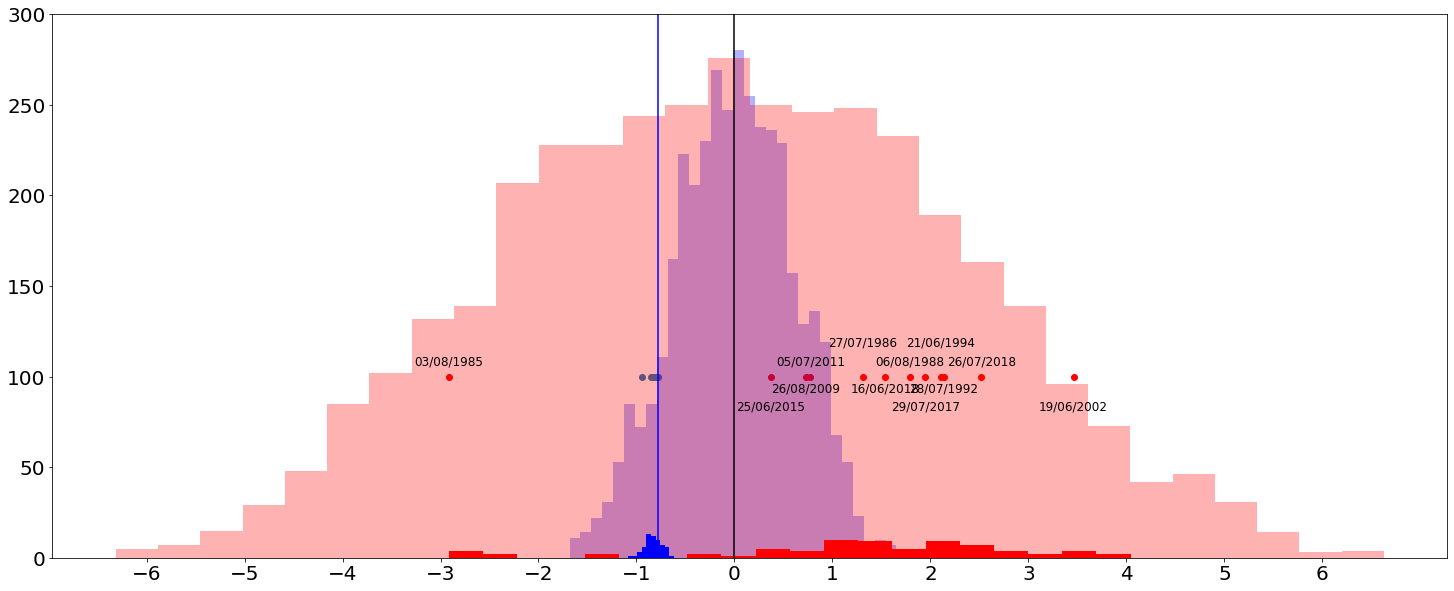

In [36]:
fig = plt.figure(figsize=(25,10))
n, bins,patches= plt.hist(sst_deseason_Atl_JJA, color='blue', bins=30, alpha = 0.3)
n, bins,patches= plt.hist(t2m_deseason_Euro_JJA, color='red', bins=30, alpha = 0.3)
plt.scatter(sst_ds_Atl_JJA_cold_negtend_concat,np.full((12), 100))
plt.plot([0,0],[0,300], color='black')
plt.ylim([0,300])
#plt.xlim([-1,-0.75])
plt.plot([quantile_10, quantile_10],[0,300], color='blue')
plt.xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
lag=3
plt.scatter(v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(lag,lag)).squeeze(),np.full((12), 100), color='red')
df=v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(lag,lag)).squeeze()
dy=[105,115,105,90,115,80,90,105,80,80,90,105]
dates_t2m =df.time.dt.strftime("%d/%m/%Y")
for i in range(0,len(dates_t2m)):
    plt.text(df[i],dy[i],dates_t2m.values[i], fontsize=12, horizontalalignment='center', verticalalignment='bottom')
    
##### Histograms for composites
# for SST between -2 and +2
sst_comb= [v_Atl_line_wtm['sst_t2m'][0].sel(lead_lag=slice(-2,-2)).squeeze(),v_Atl_line_wtm['sst_t2m'][0].sel(lead_lag=slice(-1,-1)).squeeze(),v_Atl_line_wtm['sst_t2m'][0].sel(lead_lag=slice(0,0)).squeeze(),v_Atl_line_wtm['sst_t2m'][0].sel(lead_lag=slice(1,1)).squeeze(),v_Atl_line_wtm['sst_t2m'][0].sel(lead_lag=slice(2,2)).squeeze()]
sst_cat = xr.concat(sst_comb, dim='time')

# for T2M between 2 and +7
t2m_comb= [v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(2,2)).squeeze(),v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(3,3)).squeeze(),v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(4,4)).squeeze(),v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(5,5)).squeeze(),v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(6,6)).squeeze(),v_Euro_line_wtm['sst_t2m'][0].sel(lead_lag=slice(7,7)).squeeze()]
t2m_cat = xr.concat(t2m_comb, dim='time')
plt.hist(sst_cat, bins=10, color='blue')
plt.hist(t2m_cat, bins=20, color='red')

# Save JJA to netCDF file
ds = xr.Dataset({"sst_t2m_Atl_line_wtm_downstream": (("lead_lag","time"), v_Atl_line_wtm['sst_t2m'][0]),"sst_t2m_Euro_line_wtm_downstream": (("lead_lag","time"), v_Euro_line_wtm['sst_t2m'][0]), "sst_deseason_Atl_JJA_lag0_10_concat_downstream": (("time"),sst_ds_Atl_JJA_cold_negtend_concat)},coords={"lead_lag": v_Atl_line_wtm['sst_t2m'][0].lead_lag,"time": v_Euro_line_wtm['sst_t2m'][0].time},)
#ds.attrs['title'] = ['Total wind speed 300 hPa JJA']
ds.to_netcdf('ERA5_downstream_analysis_composite_12dates.nc')

#ds = xr.Dataset({"sst_t2m_Atl_line_wtm_downstream_warm": (("lead_lag","time"), sst_t2m_Atl_line_wtm[3]),"sst_t2m_Euro_line_wtm_downstream_warm": (("lead_lag","time"), sst_t2m_Euro_line_wtm[3]), "sst_deseason_Atl_JJA_lag0_90_concat_downstream": (("time"),sst_ds_Atl_JJA_warm_negtend_concat)},coords={"lead_lag": sst_t2m_Euro_line_wtm[3].lead_lag,"time": sst_t2m_Euro_line_wtm[3].time},)
#ds.to_netcdf('ERA5_downstream_analysis_composite_dates_warm_composite.nc')

<xarray.DataArray (time: 3772)>
array([4.72244994, 4.91874092, 5.29290361, ..., 3.58626295, 3.45774179,
       4.30047815])
Coordinates:
  * time       (time) datetime64[ns] 1979-06-01T06:00:00 ... 2019-08-31T06:00:00
    dayofyear  (time) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
<xarray.DataArray (time: 3772)>
array([-0.14239726, -0.09426961, -0.07105699, ..., -0.29677996,
       -0.20732873, -0.26838148])
Coordinates:
    lead_lag  int64 1
  * time      (time) datetime64[ns] 1979-06-01T06:00:00 ... 2019-08-31T06:00:00
<xarray.DataArray (time: 3772)>
array([-0.19944635, -0.14239726, -0.09426961, ..., -0.34575616,
       -0.29677996, -0.20732873])
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01T06:00:00 ... 2019-08-31T06:00:00


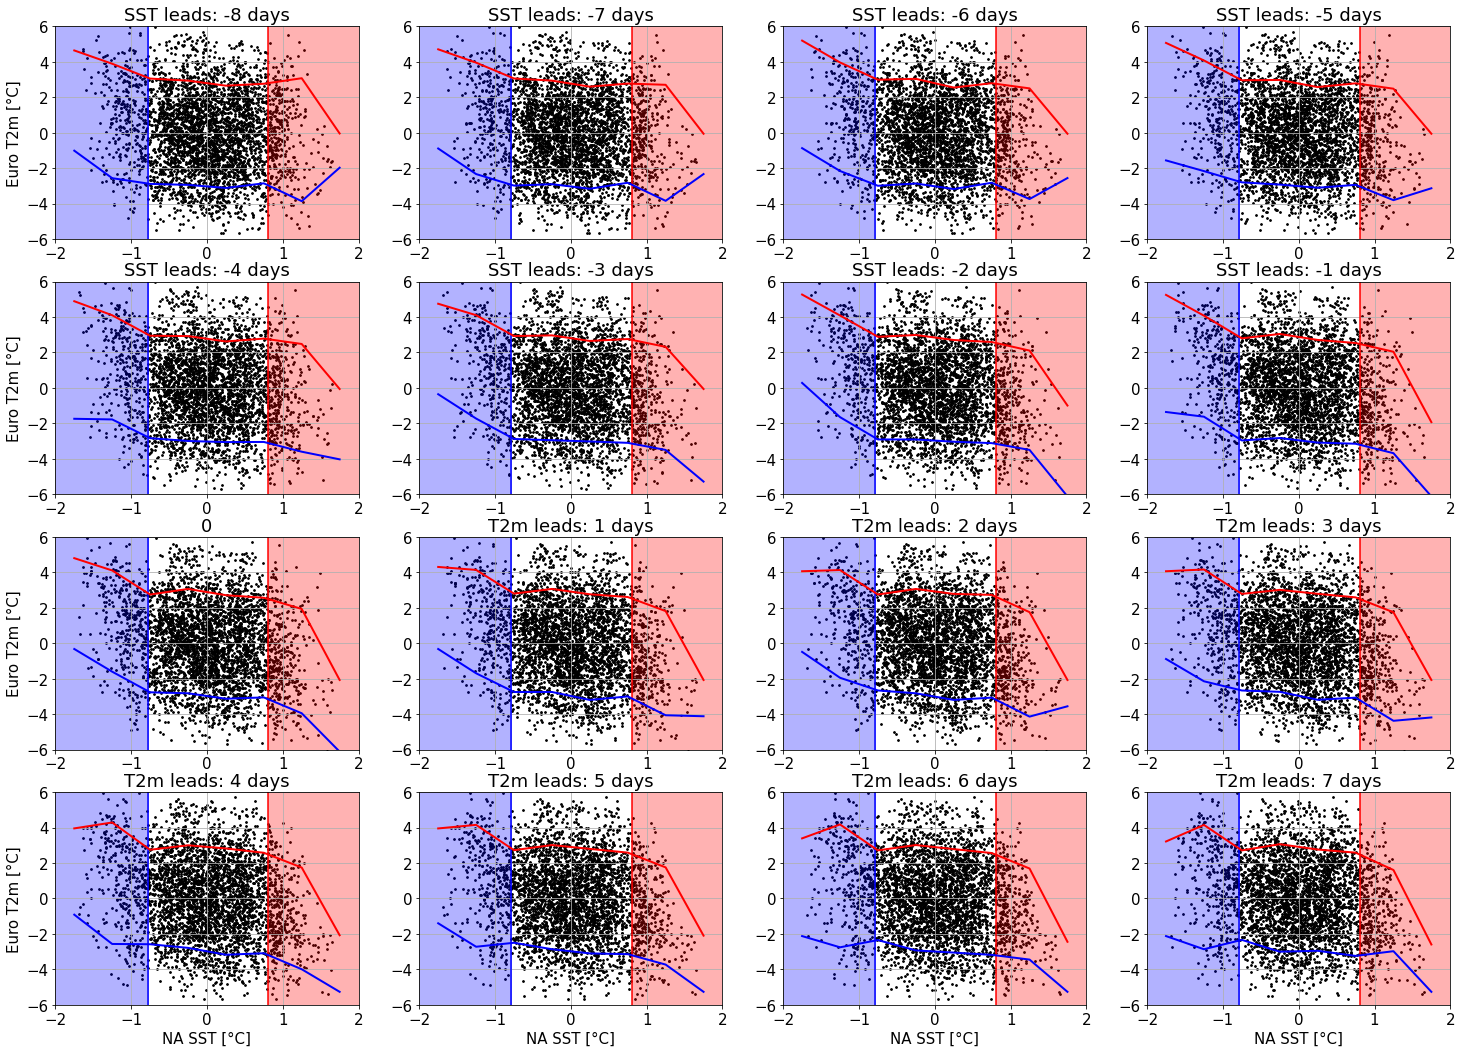

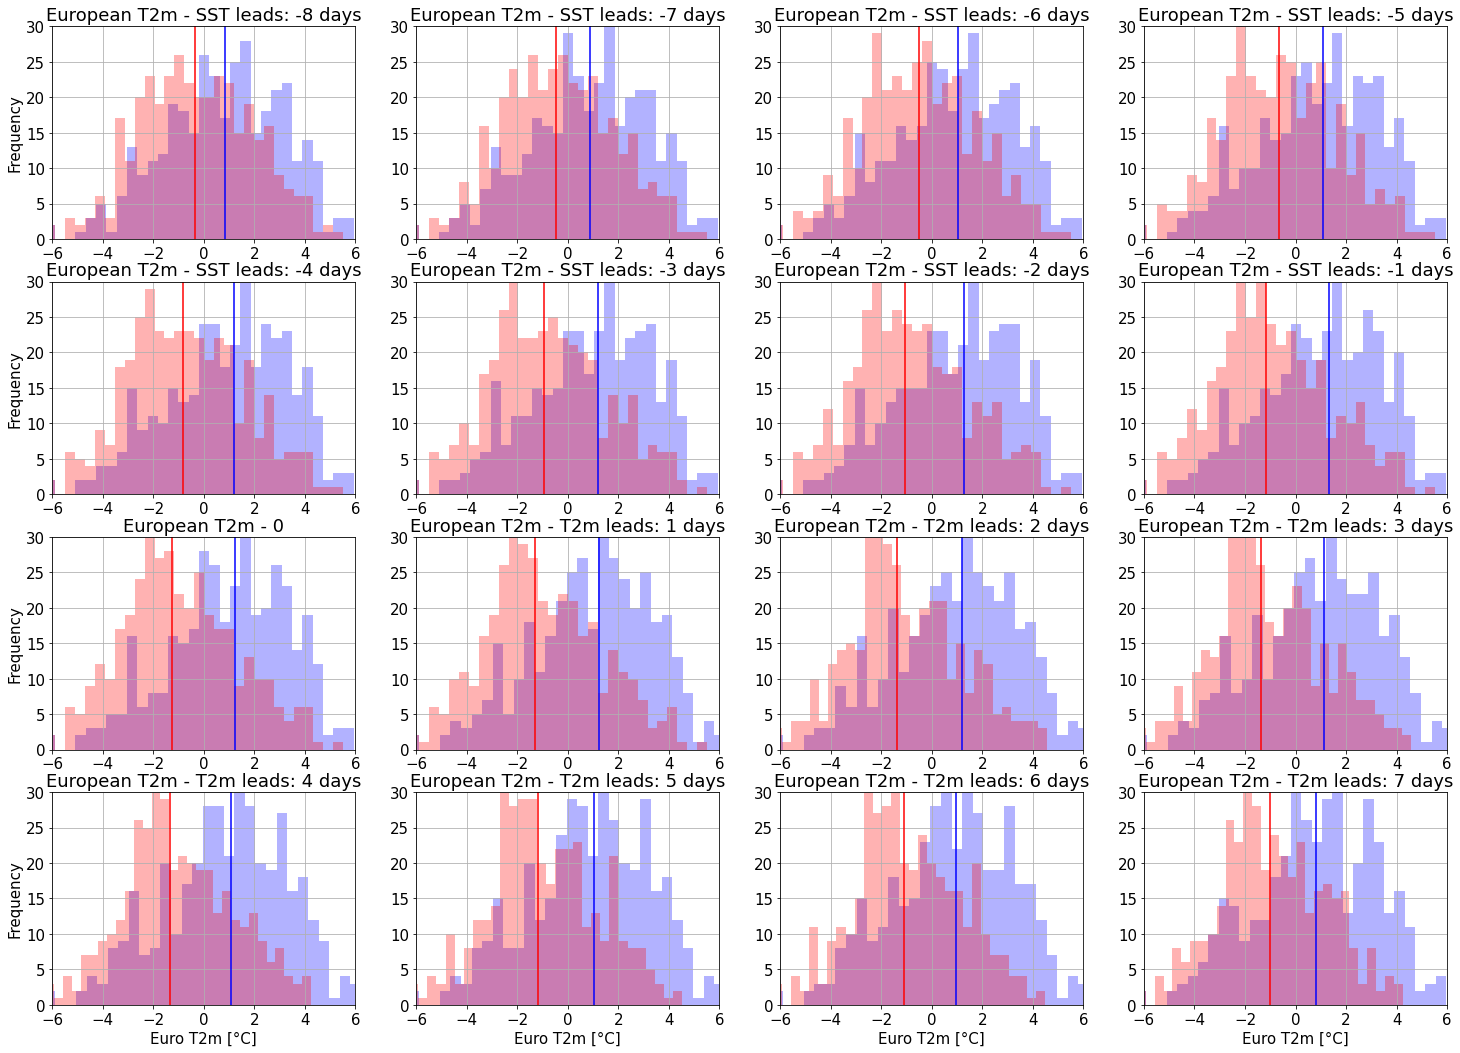

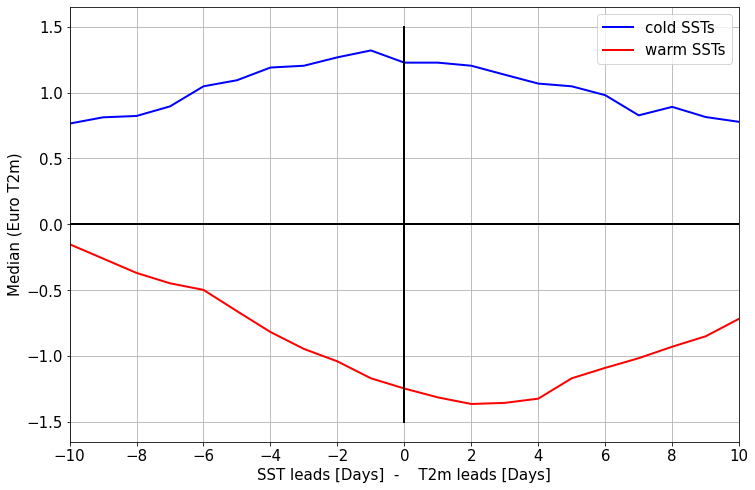

In [8]:
print(t2m_deseason_Euro_JJA)
print(sst_lags_all_JJA_set[11])
print(sst_Atl_ds_dt_xr.sel(time=sst_Atl_ds_dt_xr['time.season']==['JJA']))


#### Calc percentile lines for 8 different SST bins with interval of 0.5 °C
interv= np.linspace(-2,2,9)
spacing=0.25
t2m_deseason_Euro_JJA_binned_set_01_lag = []
t2m_deseason_Euro_JJA_binned_set_09_lag = []
for k in range(len(sst_lags_all_JJA_set.lead_lag)):
    t2m_deseason_Euro_JJA_binned_set_01 = []
    t2m_deseason_Euro_JJA_binned_set_09 = []
    for i in range(len(interv)-1):
        t2m_deseason_Euro_JJA_binned = []
        for j in range(len(sst_lags_all_JJA_set[k].time)):
            if sst_lags_all_JJA_set[k][j] > interv[i] and sst_lags_all_JJA_set[k][j] < interv[i+1]:
                t2m_deseason_Euro_JJA_binned.append(t2m_deseason_Euro_JJA[j].where(t2m_deseason_Euro_JJA[j].time == sst_lags_all_JJA_set[11][j].time))
        t2m_deseason_Euro_JJA_binned_set_01.append(xr.concat(t2m_deseason_Euro_JJA_binned, dim='time').quantile(0.1, dim='time'))
        t2m_deseason_Euro_JJA_binned_set_09.append(xr.concat(t2m_deseason_Euro_JJA_binned, dim='time').quantile(0.9, dim='time'))
    t2m_deseason_Euro_JJA_binned_set_01_lag.append(xr.concat(t2m_deseason_Euro_JJA_binned_set_01, dim='time'))
    t2m_deseason_Euro_JJA_binned_set_09_lag.append(xr.concat(t2m_deseason_Euro_JJA_binned_set_09, dim='time'))

######### Plot scatter plots
# Set general font size
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(25,18))
axs=[]
for i in range(1,17):
    axs.append(fig.add_subplot(4,4,i))
run=2
for i in range(0,16):
    axs[i].plot([quantile_10, quantile_10],[-100,100], color = 'blue')
    axs[i].plot([quantile_90, quantile_90],[-100,100], color = 'red')
    axs[i].scatter(sst_lags_all_JJA_set[run],t2m_deseason_Euro_JJA, color='black', s=3)
    axs[i].axvspan(-2, quantile_10, alpha=0.3, color='blue')
    axs[i].axvspan(quantile_90, 2, alpha=0.3, color='red')
    axs[i].plot((interv+spacing)[:-1], xr.concat(t2m_deseason_Euro_JJA_binned_set_01_lag, dim='lead_lag')[run], color='blue', linewidth=2)
    axs[i].plot((interv+spacing)[:-1], xr.concat(t2m_deseason_Euro_JJA_binned_set_09_lag, dim='lead_lag')[run], color='red', linewidth=2)

    if run<10:
        axs[i].set_title('SST leads: '+str(sst_lags_all_JJA_set[run].lead_lag.values)+' days')
    if run==10:
        axs[i].set_title(sst_lags_all_JJA_set[run].lead_lag.values)
    elif run>10: 
        axs[i].set_title('T2m leads: '+str(sst_lags_all_JJA_set[run].lead_lag.values)+' days')

    if i>11:
        axs[i].set_xlabel('NA SST [°C]')
    if i==0 or i==4 or i==8 or i==12:
        axs[i].set_ylabel('Euro T2m [°C]')

    run+=1
    
for ax in axs:
        ax.grid()
        ax.set_ylim([-6,6])
        ax.set_xlim([-2,2])
rasterize_list = [axs[0], axs[1], axs[2],axs[3],axs[4],axs[5],axs[6],axs[7],axs[8],axs[9],axs[10],axs[11],axs[12],axs[13],axs[14],axs[15]]
raster.rasterize_and_save('ERA5_sst_t2m_lags_JJA_scatter_percentiles.pdf', rasterize_list, dpi=300)


#print(len(sst_lags_all_JJA_set.lead_lag))
### Calc conditional PDFs
sst_lags_all_JJA_set_neg =[]
sst_lags_all_JJA_set_neg_med =[]
sst_lags_all_JJA_set_pos =[]
sst_lags_all_JJA_set_pos_med =[]
for i in range(len(sst_lags_all_JJA_set.lead_lag)):
    sst_lags_all_JJA_set_neg_lag =[]
    sst_lags_all_JJA_set_pos_lag =[]
    for j in range(len(sst_lags_all_JJA_set.time)):
        #print(t2m_deseason_Euro_JJA.where(t2m_deseason_Euro_JJA.time == sst_lags_all_JJA_set[i,j].time))
        if sst_lags_all_JJA_set[i,j] < quantile_10:
            sst_lags_all_JJA_set_neg_lag.append(t2m_deseason_Euro_JJA.where(t2m_deseason_Euro_JJA.time == sst_lags_all_JJA_set[i,j].time).dropna(dim='time'))
        if sst_lags_all_JJA_set[i,j] > quantile_90:
            sst_lags_all_JJA_set_pos_lag.append(t2m_deseason_Euro_JJA.where(t2m_deseason_Euro_JJA.time == sst_lags_all_JJA_set[i,j].time).dropna(dim='time'))
    sst_lags_all_JJA_set_neg.append(xr.concat(sst_lags_all_JJA_set_neg_lag, dim='time'))
    sst_lags_all_JJA_set_neg_med.append(sst_lags_all_JJA_set_neg[i].median())
    sst_lags_all_JJA_set_pos.append(xr.concat(sst_lags_all_JJA_set_pos_lag, dim='time'))
    sst_lags_all_JJA_set_pos_med.append(sst_lags_all_JJA_set_pos[i].median())
    #print(sst_lags_all_JJA_set_neg[i].shape)

######### Plot conditional PDFs
fig = plt.figure(figsize=(25,18))
axs=[]
for i in range(1,17):
    axs.append(fig.add_subplot(4,4,i))
run=2
for i in range(0,16):
    #axs[i].plot([-1,-1],[-100,100], color = 'blue')
    axs[i].hist(sst_lags_all_JJA_set_neg[run], bins=30, color='blue', alpha=0.3)
    axs[i].hist(sst_lags_all_JJA_set_pos[run], bins=30, color='red', alpha=0.3)
    axs[i].plot([sst_lags_all_JJA_set_neg[run].median().values, sst_lags_all_JJA_set_neg[run].median().values],[0,100], color='blue')
    axs[i].plot([sst_lags_all_JJA_set_pos[run].median().values, sst_lags_all_JJA_set_pos[run].median().values],[0,100], color='red')

    if run<10:
        axs[i].set_title('European T2m - SST leads: '+str(sst_lags_all_JJA_set[run].lead_lag.values)+' days')
    if run==10:
        axs[i].set_title('European T2m - '+str(sst_lags_all_JJA_set[run].lead_lag.values))
    elif run>10: 
        axs[i].set_title('European T2m - T2m leads: '+str(sst_lags_all_JJA_set[run].lead_lag.values)+' days')

    if i>11:
        axs[i].set_xlabel('Euro T2m [°C]')
    if i==0 or i==4 or i==8 or i==12:
        axs[i].set_ylabel('Frequency')
    run+=1
for ax in axs:
        ax.grid()
        ax.set_xlim([-6,6])
        ax.set_ylim([0,30])
rasterize_list = [axs[0], axs[1], axs[2],axs[3],axs[4],axs[5],axs[6],axs[7],axs[8],axs[9],axs[10],axs[11],axs[12],axs[13],axs[14],axs[15]]
raster.rasterize_and_save('ERA5_sst_t2m_lags_JJA_cond_PDF.pdf', rasterize_list, dpi=300)

fig = plt.figure(figsize=(12,8))
axs=[]
for i in range(1,2):
    axs.append(fig.add_subplot(1,1,i))
axs[0].plot(sst_lags_all_JJA_set.lead_lag, xr.concat(sst_lags_all_JJA_set_neg_med, dim='time'), linewidth=2, color='blue', label='cold SSTs')
axs[0].plot(sst_lags_all_JJA_set.lead_lag, xr.concat(sst_lags_all_JJA_set_pos_med, dim='time'), linewidth=2, color='red', label='warm SSTs')
axs[0].plot([-10,10], [0,0], linewidth=2, color='black')
axs[0].plot([0,0], [-1.5,1.5], linewidth=2, color='black')

axs[0].grid()
axs[0].set_xlabel('SST leads [Days]  -    T2m leads [Days]')
axs[0].set_ylabel('Median (Euro T2m)')
axs[0].set_xlim([-10,10])
axs[0].set_xticks([-10,-8,-6,-4,-2,0,2,4,6,8,10])
plt.legend()
rasterize_list = [axs[0]]
raster.rasterize_and_save('ERA5_sst_t2m_lags_JJA_median.pdf', rasterize_list, dpi=300)


# Animations

## Make animation with SST/T2M (coloured) and Z300 (contour) from -60 to 60 for COLD events

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


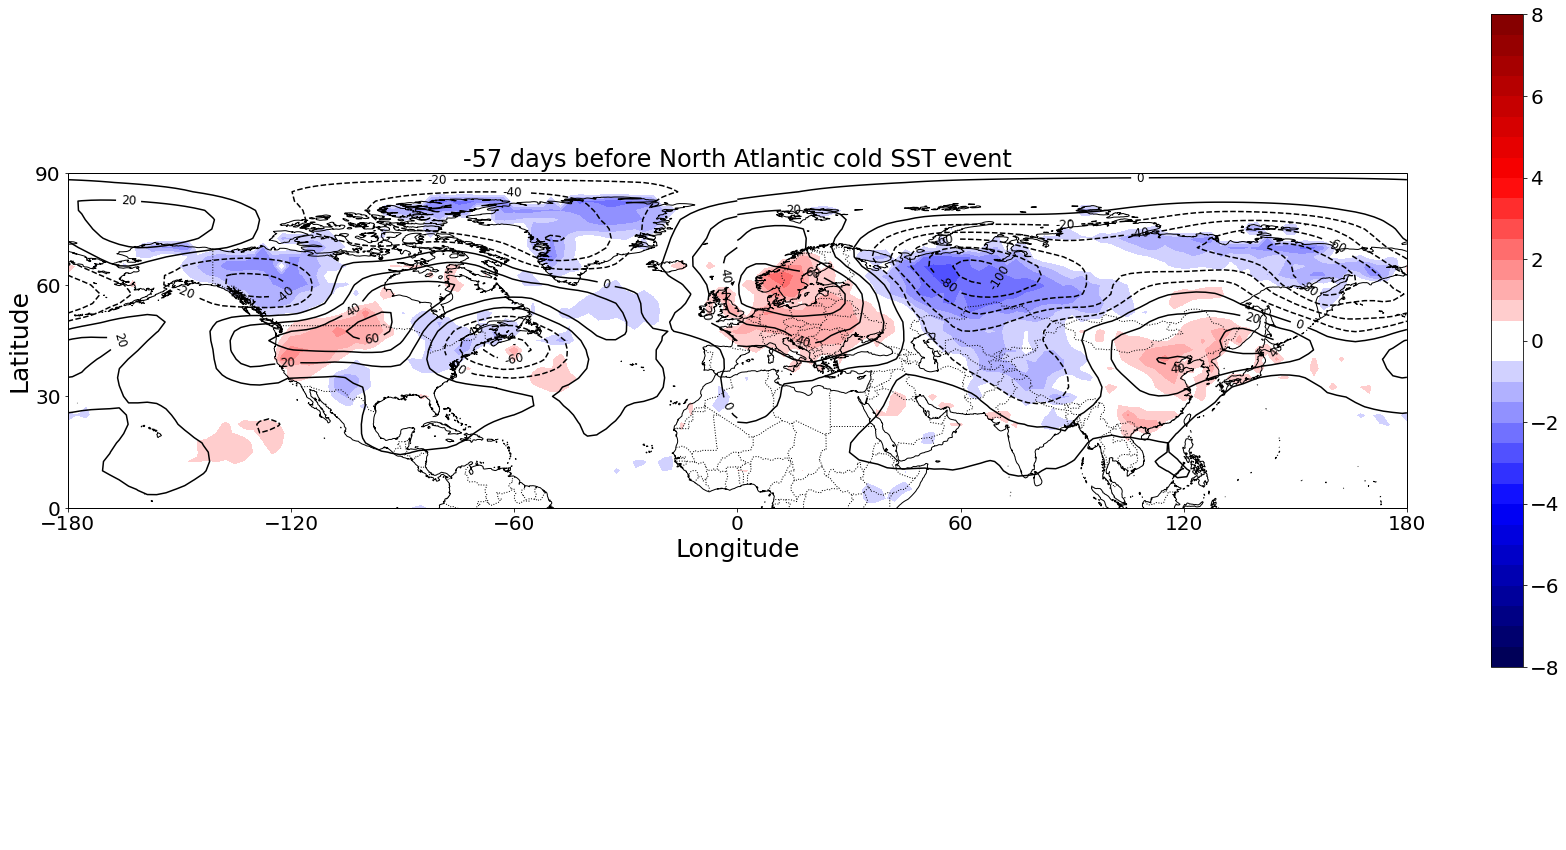

In [14]:
#SST_T2M_10_lags_mean=[]
#SST_T2M_10_lags_welch=[]
#for i in range(len(SST_T2M_10_lags)):
#    SST_T2M_10_lags_mean.append(SST_T2M_10_lags[i].mean('time'))
#    SST_T2M_10_lags_welch.append(xr.DataArray(data=(ttest_ind(SST_T2M_10_lags[i], SST_T2M_medium_lags[i], equal_var=False).pvalue), dims=[ "lat", "lon"], coords=dict(lon = SST_T2M_10_lags[0].lon,lat= SST_T2M_10_lags[0].lat, lead_lag= SST_T2M_10_lags[i].lead_lag)))

#SST_T2M_10_lags_mean_combined = xr.concat(SST_T2M_10_lags_mean, dim='lead_lag')
#SST_T2M_10_lags_welch_combined = xr.concat(SST_T2M_10_lags_welch, dim='lead_lag')

#z_10_lags_mean= []
#for i in range(len(z_10_lags)):
#        z_10_lags_mean.append(z_10_lags[i].mean('time')/9.81)
#z_10_lags_mean_combined = xr.concat(z_10_lags_mean, dim='lead_lag')



##### Plot global map

fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=prj)
ax.coastlines('50m')
clevels = np.linspace(-160,160,17)
levels = np.linspace(-8,8,33)
lon=np.linspace(0,360,144)
X1, Y1 = np.meshgrid(lon, ds_ERA5_z.latitude)

contf= ax.contourf(X,Y, np.c_[sst_t2m_map[0][0,:,:], sst_t2m_map[0][0,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels)
cont= ax.contour(X1,Y1, z_map[0][0,:,:], transform=prj, levels=clevels)
cb = plt.colorbar(contf)

def animate(i):
    ax.clear()
    ax.coastlines('50m')
    contf= ax.contourf(X,Y, np.c_[sst_t2m_map[0][i,:,:], sst_t2m_map[0][i,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels, extend='both')
    ax.set_xticks([-180, -120, -60,0, 60, 120, 180],crs=prj)
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90],crs=prj)
    ax.set_xlabel('Longitude', fontsize=25)
    ax.set_ylabel('Latitude', fontsize=25)
    ax.add_feature(cartopy.feature.BORDERS, ls=':')
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.05), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.05)],1, hatches=['','**'], alpha=0)
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.1), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.1)],1, hatches=['','..'], alpha=0)
    cont= ax.contour(X1,Y1, z_map[0][i,:,:], transform=prj, levels=clevels, colors='black')
    ax.clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    ax.set_extent([-180, 180, 0, 90],prj)

    if i< 57: 
        ax.set_title(str(i-57)+ ' days before North Atlantic cold SST event')
    elif i == 57:
        ax.set_title(str(i-57))
    else: 
        ax.set_title(str(i-57)+ ' days after North Atlantic cold SST event')
    return cont, contf

anim = animation.FuncAnimation(fig,animate, save_count=115)
writergif = animation.PillowWriter(fps=2) 
#anim.save('SST_T2M_Z300_cold_events_global_anim.gif', writer=writergif)

## Make animation with SST/T2M (coloured) and Z300 (contour) from -60 to 60 for COLD events: North Atlantic - European sector only

In [ ]:
##### Plot North Atlantic 

fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
clevels = np.linspace(-150,150,21)
levels = np.linspace(-3,3,13)
contf= ax.contourf(X,Y, np.c_[sst_t2m_map[0][0,:,:], sst_t2m_map[0][0,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels)
cont= ax.contour(X1,Y1, z_map[0][0,:,:], levels=clevels, transform=prj, colors='black')
cb = plt.colorbar(contf)
cb.set_label('SST/T2m anomaly [°C]', size='large')
#ax.add_feature(cartopy.feature.LAND, color='black')
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines('50m')

def animate(i):
    ax.clear()
    ax.coastlines('50m', lw=2)
    contf= ax.contourf(X,Y, np.c_[sst_t2m_map[0][i,:,:], sst_t2m_map[0][i,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels, extend='both')
    ax.set_xticks([-60,-40,-20,0, 20, 40, 60],crs=prj)
    ax.set_yticks([0,30,45,60,75],crs=prj)
    ax.set_xlabel('Longitude', fontsize=25)
    ax.set_ylabel('Latitude', fontsize=25)
    ax.add_feature(cartopy.feature.BORDERS, ls=':')
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.05), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.05)],1, hatches=['','**'], alpha=0)
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.1), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.1)],1, hatches=['','..'], alpha=0)
    cont= ax.contour(X1,Y1, z_map[0][i,:,:], levels=clevels, transform=prj, colors='black')
    ax.clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    ax.set_extent([-60, 40, 30, 70],prj)


    if i< 57: 
        ax.set_title(str(i-57)+ ' days before cold North Atlantic SST event')
    elif i == 57:
        ax.set_title(str(i-57))
    else: 
        ax.set_title(str(i-57)+ ' days after cold North Atlantic SST event')
    return cont, contf

anim = animation.FuncAnimation(fig,animate, save_count=115)

# Save as gif
writergif = animation.PillowWriter(fps=2) 
anim.save('SST_T2M_Z300_cold_events_NA_anim.gif', writer=writergif)

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


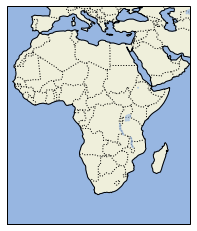

In [86]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.set_extent([-20, 60, -40, 40])
plt.show()


## Make animation with SST/T2M (coloured) and Z300 (contour) from -60 to 60 for WARM events

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


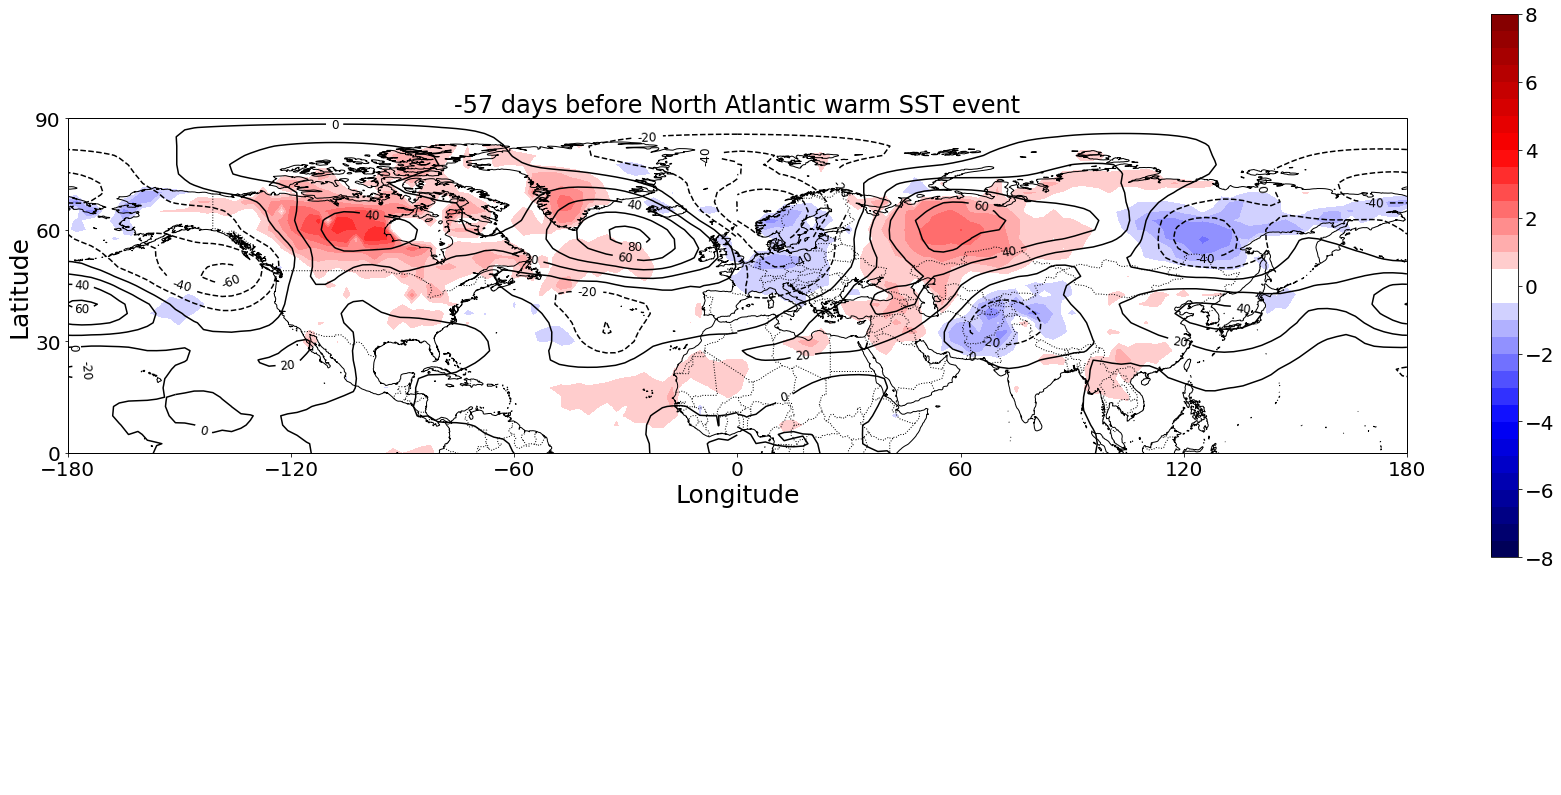

In [86]:
#SST_T2M_90_lags_mean=[]
#SST_T2M_90_lags_welch=[]
#for i in range(len(SST_T2M_90_lags)):
#    SST_T2M_90_lags_mean.append(SST_T2M_90_lags[i].mean('time'))
#    SST_T2M_90_lags_welch.append(xr.DataArray(data=(ttest_ind(SST_T2M_90_lags[i], SST_T2M_medium_lags[i], equal_var=False).pvalue), dims=[ "lat", "lon"], coords=dict(lon = SST_T2M_90_lags[0].lon,lat= SST_T2M_90_lags[0].lat, lead_lag= SST_T2M_90_lags[i].lead_lag)))

#SST_T2M_90_lags_mean_combined = xr.concat(SST_T2M_90_lags_mean, dim='lead_lag')
#SST_T2M_90_lags_welch_combined = xr.concat(SST_T2M_90_lags_welch, dim='lead_lag')

#z_90_lags_mean= []
#for i in range(len(z_90_lags)):
#        z_90_lags_mean.append(z_90_lags[i].mean('time')/9.81)
#z_90_lags_mean_combined = xr.concat(z_90_lags_mean, dim='lead_lag')


##### Plot global map

fig = plt.figure(figsize=(30,10))
ax = plt.axes(projection=prj)
ax.coastlines('50m')
clevels = np.linspace(-160,160,17)
levels = np.linspace(-8,8,33)
lon=np.linspace(0,360,144)
X1, Y1 = np.meshgrid(lon, ds_ERA5_z.latitude)

contf= ax.contourf(X,Y, np.c_[sst_t2m_map[1][0,:,:], sst_t2m_map[1][0,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels)
cont= ax.contour(X1,Y1, z_map[1][0,:,:], transform=prj, levels=clevels)
plt.colorbar(contf)

def animate(i):
    ax.clear()
    ax.coastlines('50m')
    contf= ax.contourf(X,Y, np.c_[sst_t2m_map[1][i,:,:], sst_t2m_map[1][i,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels, extend='both')
    ax.set_xticks([-180, -120, -60,0, 60, 120, 180],crs=prj)
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90],crs=prj)
    ax.set_xlabel('Longitude', fontsize=25)
    ax.set_ylabel('Latitude', fontsize=25)
    ax.add_feature(cartopy.feature.BORDERS, ls=':')
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.05), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.05)],1, hatches=['','**'], alpha=0)
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.1), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.1)],1, hatches=['','..'], alpha=0)
    cont= ax.contour(X1,Y1, z_map[1][i,:,:], transform=prj, levels=clevels, colors='black')
    ax.clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    ax.set_extent([-180, 180, 0, 90],prj)

    if i< 57: 
        ax.set_title(str(i-57)+ ' days before North Atlantic warm SST event')
    elif i == 57:
        ax.set_title(str(i-57))
    else: 
        ax.set_title(str(i-57)+ ' days after North Atlantic warm SST event')
    return cont, contf

anim = animation.FuncAnimation(fig,animate, save_count=115)
writergif = animation.PillowWriter(fps=2) 
anim.save('SST_T2M_Z300_warm_events_NH_anim.gif', writer=writergif)

## Make animation with SST/T2M (coloured) and Z300 (contour) from -60 to 60 for WARM events: North Atlantic - European sector only

/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/jukrueger/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


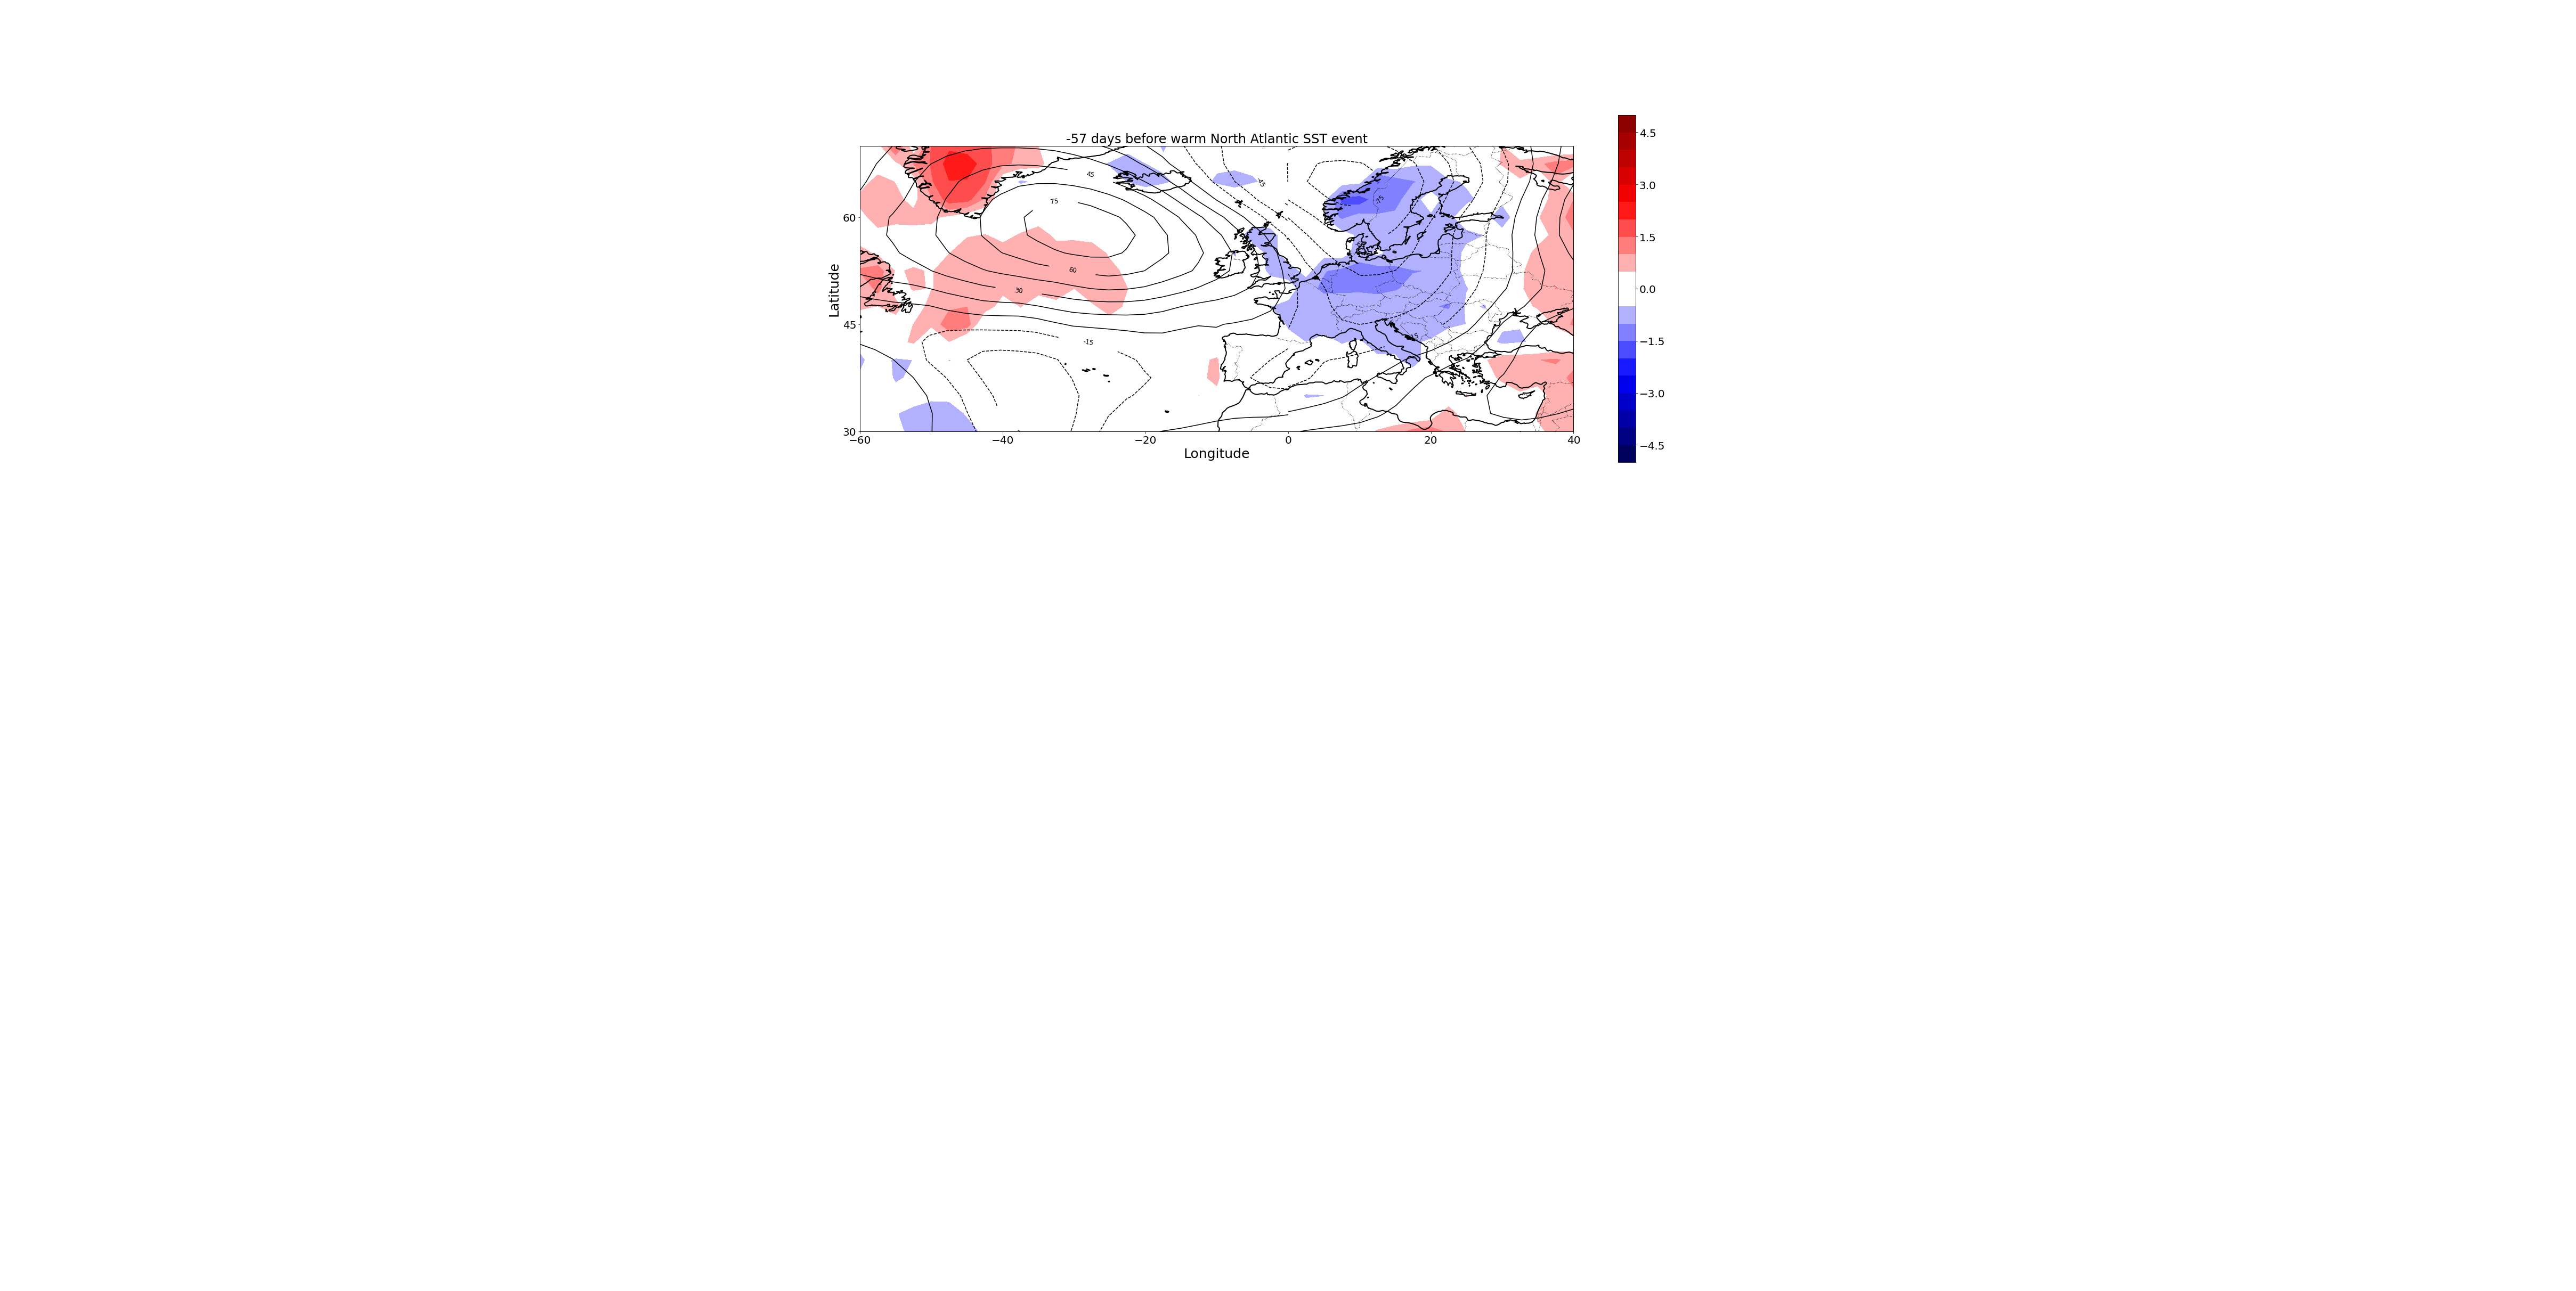

In [81]:
##### Plot North Atlantic 

fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
clevels = np.linspace(-150,150,21)
levels = np.linspace(-5,5,21)
contf= ax.contourf(X,Y, np.c_[sst_t2m_map[1][0,:,:], sst_t2m_map[1][0,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels)
cont= ax.contour(X1,Y1, z_map[1][0,:,:], levels=clevels, transform=prj, colors='black')
plt.colorbar(contf)
#ax.add_feature(cartopy.feature.LAND, color='black')
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines('50m')

def animate(i):
    ax.clear()
    ax.coastlines('50m', lw=2)
    ax.set_xticks([-60,-40,-20,0, 20, 40, 60],crs=prj)
    ax.set_yticks([0,30,45,60,75],crs=prj)
    ax.set_xlabel('Longitude', fontsize=25)
    ax.set_ylabel('Latitude', fontsize=25)
    ax.add_feature(cartopy.feature.BORDERS, ls=':')
    contf= ax.contourf(X,Y, np.c_[sst_t2m_map[1][i,:,:], sst_t2m_map[1][i,:,0]], cmap=seismic_white_cm, transform=prj, levels=levels, extend='both')
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.05), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.05)],1, hatches=['','**'], alpha=0)
    #ax.contourf(X,Y, np.c_[(SST_T2M_10_lags_welch_combined[i,:,:]< 0.1), (SST_T2M_10_lags_welch_combined[i,:,0]< 0.1)],1, hatches=['','..'], alpha=0)
    cont= ax.contour(X1,Y1, z_map[1][i,:,:], levels=clevels, transform=prj, colors='black')
    ax.clabel(cont, inline=True, fmt='%1.0f', fontsize=12)
    ax.set_extent([-60, 40, 30, 70],prj)


    if i< 57: 
        ax.set_title(str(i-57)+ ' days before warm North Atlantic SST event')
    elif i == 57:
        ax.set_title(str(i-57))
    else: 
        ax.set_title(str(i-57)+ ' days after warm North Atlantic SST event')
    return cont, contf

anim = animation.FuncAnimation(fig,animate, save_count=115)

# Save as gif
writergif = animation.PillowWriter(fps=2) 
anim.save('SST_T2M_Z300_warm_events_NA_anim.gif', writer=writergif)

## Appendix: Case studies of heat wave years 1992, 1994, 2003, 2010, 2015, 2018 & Composite of older wind speed maximum plot

* U + V - 300hPa

In [866]:
#### Load U and V and calc total wind speed
U_tot = xr.ufuncs.sqrt(ds_ERA5_u.u *ds_ERA5_u.u + ds_ERA5_v.v*ds_ERA5_v.v)
year=['1992','1994','2003','2010','2015','2018']
U_tot_May_append =[]
U_tot_Jun_append =[]
U_tot_Jul_append =[]
U_tot_Aug_append =[]
for i in range(0,len(year)):
    U_tot_May_append.append(U_tot.sel(time=slice(year[i]+'-05-01T06:00:00',year[i]+'-05-31T06:00:00')).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time'))
    U_tot_Jun_append.append(U_tot.sel(time=slice(year[i]+'-06-01T06:00:00',year[i]+'-06-30T06:00:00')).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time'))
    U_tot_Jul_append.append(U_tot.sel(time=slice(year[i]+'-07-01T06:00:00',year[i]+'-07-31T06:00:00')).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time'))
    U_tot_Aug_append.append(U_tot.sel(time=slice(year[i]+'-08-01T06:00:00',year[i]+'-08-31T06:00:00')).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time'))

#### produce meridional wind anomalies for 1992, 1994, 2003, 2010, 2015 and 2018
v_clim = ds_ERA5_v.v.groupby('time.season').mean('time')
v_clim_month = ds_ERA5_v.v.groupby('time.month').mean('time')

v_anom_May_append=[]
v_anom_Jun_append=[]
v_anom_Jul_append=[]
v_anom_Aug_append=[]
for i in range(0,len(year)):
    v_anom_May_append.append(ds_ERA5_v.v.sel(time=slice(year[i]+'-05-01T06:00:00',year[i]+'-05-31T06:00:00')).mean('time') - v_clim_month.sel(month=5))
    v_anom_Jun_append.append(ds_ERA5_v.v.sel(time=slice(year[i]+'-06-01T06:00:00',year[i]+'-06-30T06:00:00')).mean('time') - v_clim_month.sel(month=6))
    v_anom_Jul_append.append(ds_ERA5_v.v.sel(time=slice(year[i]+'-07-01T06:00:00',year[i]+'-07-31T06:00:00')).mean('time') - v_clim_month.sel(month=7))
    v_anom_Aug_append.append(ds_ERA5_v.v.sel(time=slice(year[i]+'-08-01T06:00:00',year[i]+'-08-31T06:00:00')).mean('time') - v_clim_month.sel(month=8))

v_anom_set=[]
for i in range(0,6):
    v_anom_set.append((v_anom_May_append[i] + v_anom_Jun_append[i] + v_anom_Jul_append[i] + v_anom_Aug_append[i])/4)

* Z - 300hPa

In [867]:
z_clim_month = ds_ERA5_z.z.groupby('time.month').mean('time')
z_clim = ds_ERA5_z.z.groupby('time.season').mean('time')

z_May_append =[]
z_Jun_append =[]
z_Jul_append =[]
z_Aug_append =[]
for i in range(0,len(year)):
    z_May_append.append(ds_ERA5_z.z.sel(time=slice(year[i]+'-05-01T06:00:00',year[i]+'-05-31T06:00:00')).mean('time') - z_clim_month.sel(month=5))
    z_Jun_append.append(ds_ERA5_z.z.sel(time=slice(year[i]+'-06-01T06:00:00',year[i]+'-06-30T06:00:00')).mean('time') - z_clim_month.sel(month=6))
    z_Jul_append.append(ds_ERA5_z.z.sel(time=slice(year[i]+'-07-01T06:00:00',year[i]+'-07-31T06:00:00')).mean('time') - z_clim_month.sel(month=7))
    z_Aug_append.append(ds_ERA5_z.z.sel(time=slice(year[i]+'-08-01T06:00:00',year[i]+'-08-31T06:00:00')).mean('time') - z_clim_month.sel(month=8))
    
z_anom_1992 = (z_May_append[0] +  z_Jun_append[0] + z_Jul_append[0] + z_Aug_append[0])/4
z_anom_1994 = (z_May_append[1] +  z_Jun_append[1] + z_Jul_append[1] + z_Aug_append[1])/4
z_anom_2003 = (z_May_append[2] +  z_Jun_append[2] + z_Jul_append[2] + z_Aug_append[2])/4
z_anom_2010 = (z_May_append[3] +  z_Jun_append[3] + z_Jul_append[3] + z_Aug_append[3])/4
z_anom_2015 = (z_May_append[4] +  z_Jun_append[4] + z_Jul_append[4] + z_Aug_append[4])/4
z_anom_2018 = (z_May_append[5] +  z_Jun_append[5] + z_Jul_append[5] + z_Aug_append[5])/4
z_anom = [z_anom_1992, z_anom_1994, z_anom_2003, z_anom_2010, z_anom_2015, z_anom_2018]

* SST & T2M

In [875]:
# Calc detrended monthly MJJA anomalies
# ...only for heat wave seasons
# Calc climatology
sst_t2m_detrend_clim = sst_t2m_detrend_xr.groupby('time.season').mean('time')
sst_t2m_detrend_clim_month = sst_t2m_detrend_xr.groupby('time.month').mean('time')

sst_t2m_May_append =[]
sst_t2m_Jun_append =[]
sst_t2m_Jul_append =[]
sst_t2m_Aug_append =[]
year=['1992','1994','2003','2010','2015','2018']
for i in range(0,len(year)):
        sst_t2m_May_append.append(sst_t2m_detrend_xr.sel(time=slice(year[i]+'-05-01 11:30:00',year[i]+'-05-31 11:30:00')).mean('time') - sst_t2m_detrend_clim_month.sel(month=5))
        sst_t2m_Jun_append.append(sst_t2m_detrend_xr.sel(time=slice(year[i]+'-06-01 11:30:00',year[i]+'-06-30 11:30:00')).mean('time') - sst_t2m_detrend_clim_month.sel(month=6))
        sst_t2m_Jul_append.append(sst_t2m_detrend_xr.sel(time=slice(year[i]+'-07-01 11:30:00',year[i]+'-07-31 11:30:00')).mean('time') - sst_t2m_detrend_clim_month.sel(month=7))
        sst_t2m_Aug_append.append(sst_t2m_detrend_xr.sel(time=slice(year[i]+'-08-01 11:30:00',year[i]+'-08-31 11:30:00')).mean('time') - sst_t2m_detrend_clim_month.sel(month=8))

sst_t2m_anom=[]
for i in range(0,6):
    sst_t2m_anom.append((sst_t2m_May_append[i] + sst_t2m_Jun_append[i] + sst_t2m_Jul_append[i] + sst_t2m_Aug_append[i])/4)

/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should b

<Figure size 864x720 with 0 Axes>

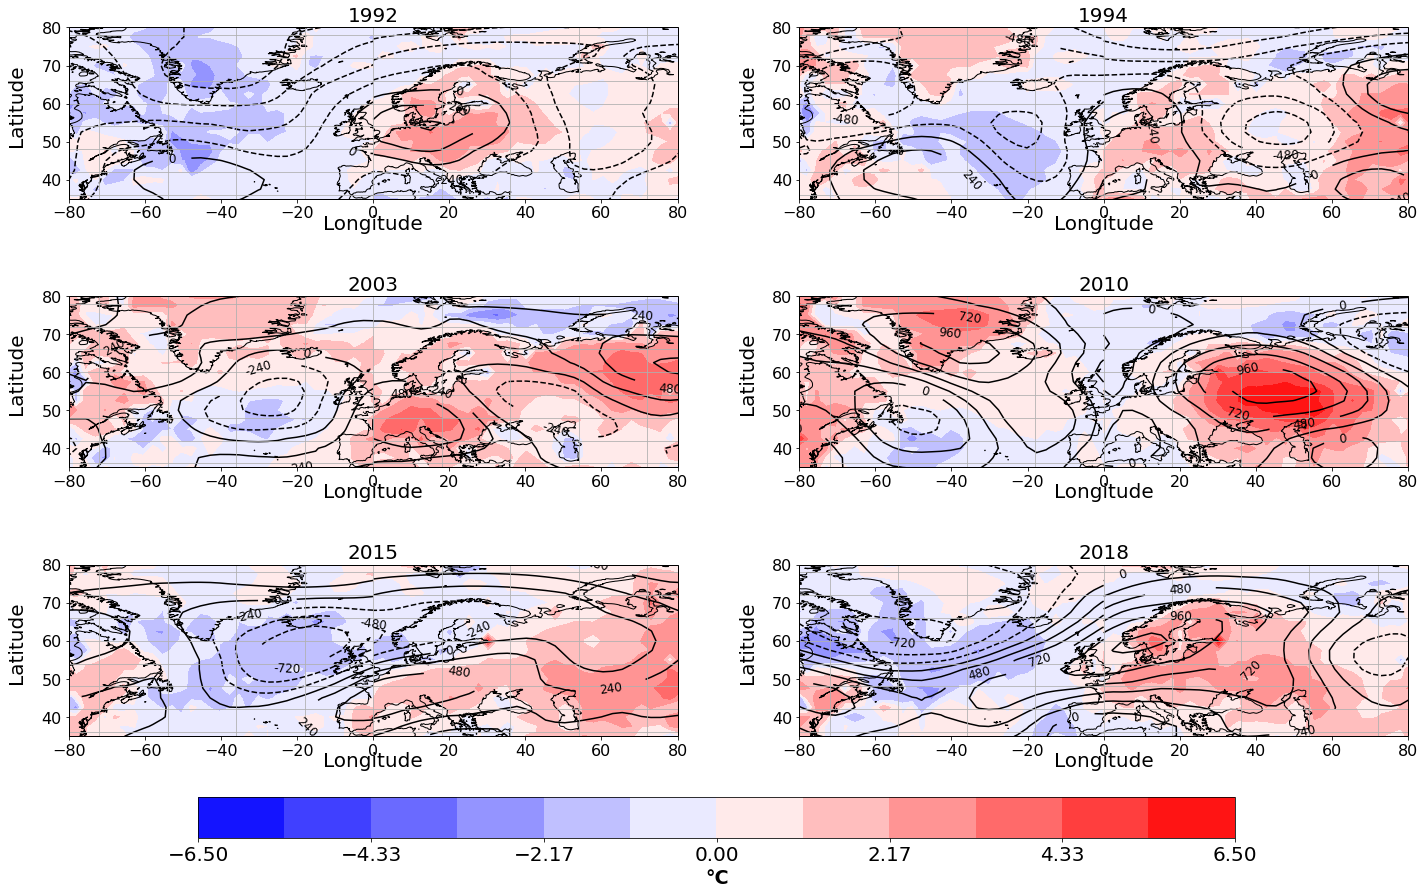

In [868]:
# Show North Atlantic European sector
fig = plt.figure(figsize=(12,10))
prj = ccrs.PlateCarree()
X, Y = np.linspace(0,360, 144), z_anom_2018.latitude
l=np.linspace(0,360,145)
clevels= np.linspace(-1200,1200, 11)
levels = np.linspace(-6.5,6.5,13)
fig= plt.figure(figsize=(24,14))
titles=['1992','1994','2003','2010','2015','2018']
axs=[]
for i in range(1,7):
    axs.append(fig.add_subplot(3,2,i, projection=prj))
for i in range(0,6):
    cont= axs[i].contourf(X,Y,sst_t2m_anom[i], cmap='bwr', transform=prj, levels=levels)
    c = axs[i].contour(X,Y, z_anom[i],colors='black', transform=prj,levels = clevels)
    axs[i].clabel(c, inline=True, fmt='%1.0f', fontsize=12)
    axs[i].set_title(titles[i], size=20)
for ax in axs:
    ax.coastlines('50m')
    ax.set_extent([-80, 80, 35, 80], ccrs.PlateCarree())
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.set_xticks([-80, -60, -40, -20,0,20, 40, 60, 80],crs=prj)
    ax.set_yticks([40, 50, 60, 70,80],crs=prj)
    ax.gridlines()


cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.04])
cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='°C', size='large', weight='bold')
plt.savefig('ERA5_sst_t2m_z300_anom_92_94_03_10_15_18.pdf')

In [869]:
#### Make composites with total wind speed U tot
U_tot_10 = U_tot.where(U_tot.time == sst_deseason_Atl_10.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time')
U_tot_25 = U_tot.where(U_tot.time == sst_deseason_Atl_25.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time')
U_tot_25_std = U_tot.where(U_tot.time == sst_deseason_Atl_25.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').std('time')
U_tot_medium = U_tot.where(U_tot.time == sst_deseason_Atl_medium.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time')
U_tot_medium_std = U_tot.where(U_tot.time == sst_deseason_Atl_medium.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').std('time')/(xr.ufuncs.sqrt(len(sst_deseason_Atl_medium.time)))
U_tot_75 = U_tot.where(U_tot.time == sst_deseason_Atl_75.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time')
U_tot_75_std = U_tot.where(U_tot.time == sst_deseason_Atl_75.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').std('time')
U_tot_90 = U_tot.where(U_tot.time == sst_deseason_Atl_90.time).sel(latitude=slice(90.0,45.0)).idxmax(dim='latitude').mean('time')

U_comp_cold_diff = U_tot_25 - U_tot_medium
U_comp_warm_diff = U_tot_75 - U_tot_medium
U_cold_medium_std_diff =  U_tot_medium_std
U_warm_medium_std_diff =  - U_tot_medium_std

/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/shkjkrug/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should b

<Figure size 864x720 with 0 Axes>

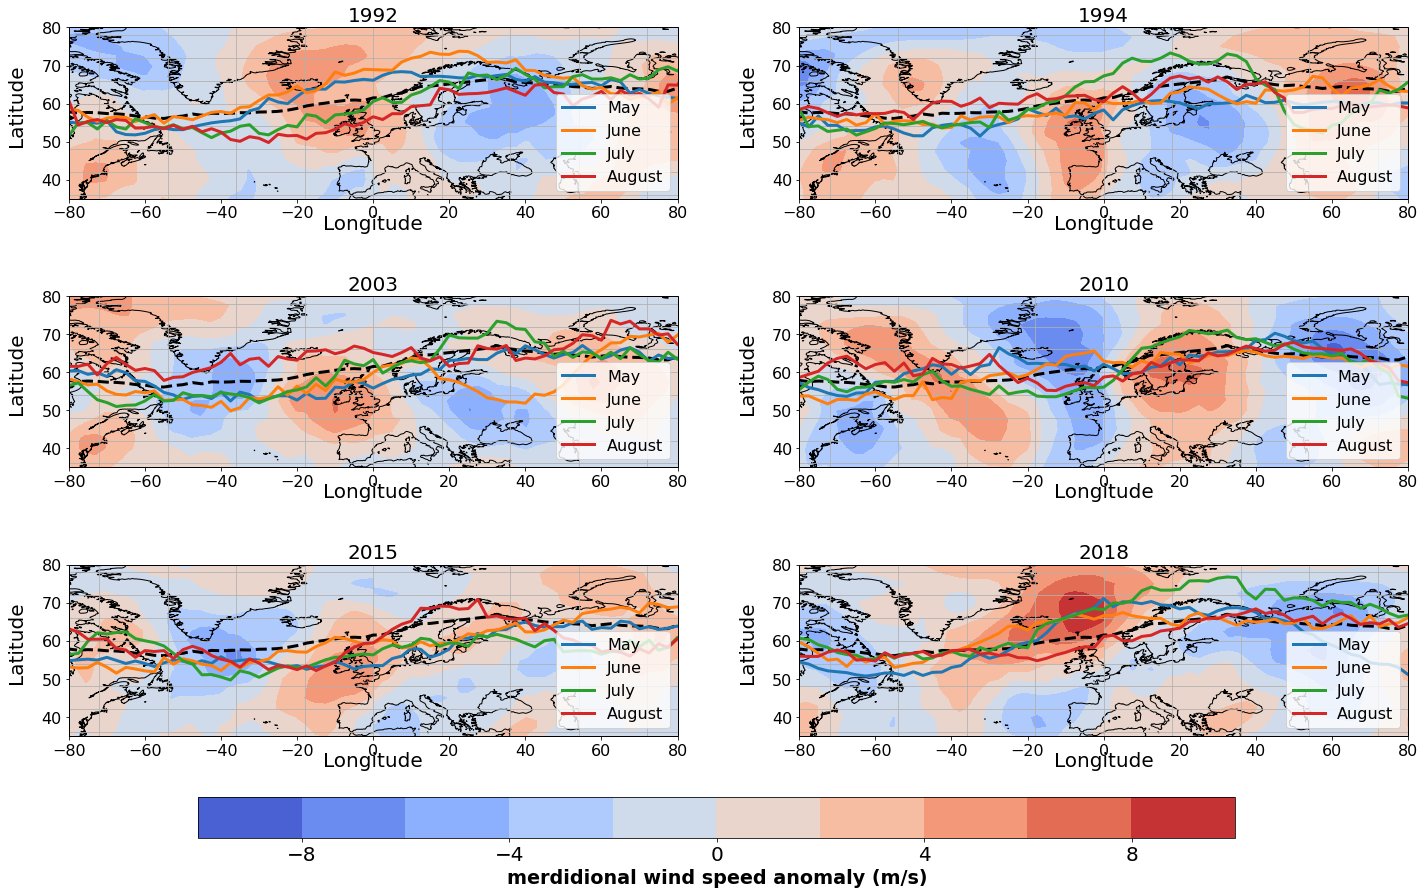

In [870]:
# Show North Atlantic European sector
fig = plt.figure(figsize=(12,10))
prj = ccrs.PlateCarree()
X, Y = np.linspace(0,360, 144), v_anom_2018.latitude
l=np.linspace(0,360,145)
levels= np.linspace(-10,10, 11)
fig= plt.figure(figsize=(24,14))
titles=['1992','1994','2003','2010','2015','2018']
axs=[]
for i in range(1,7):
    axs.append(fig.add_subplot(3,2,i, projection=prj))
for i in range(0,6):
    p2 = axs[i].plot(l, np.r_[U_tot_medium, U_tot_medium[0]], transform=prj, color='black', linewidth=3, linestyle='--')
    cont = axs[i].contourf(X,Y, v_anom_set[i], cmap='coolwarm', transform=prj,levels = levels)
    axs[i].set_title(titles[i], size=20)
    axs[i].plot(l, np.r_[U_tot_May_append[i], U_tot_May_append[i][0]], transform=prj, linewidth=3, linestyle='-', label='May')
    axs[i].plot(l, np.r_[U_tot_Jun_append[i], U_tot_Jun_append[i][0]], transform=prj, linewidth=3, linestyle='-', label='June')
    axs[i].plot(l, np.r_[U_tot_Jul_append[i], U_tot_Jul_append[i][0]], transform=prj, linewidth=3, linestyle='-', label='July')
    axs[i].plot(l, np.r_[U_tot_Aug_append[i], U_tot_Aug_append[i][0]], transform=prj, linewidth=3, linestyle='-', label='August')
    axs[i].legend()
for ax in axs:
    ax.coastlines('50m')
    ax.set_extent([-80, 80, 35, 80], ccrs.PlateCarree())
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.set_xticks([-80, -60, -40, -20,0,20, 40, 60, 80],crs=prj)
    ax.set_yticks([40, 50, 60, 70,80],crs=prj)
    ax.gridlines()


cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.04])
cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.set_label(label='merdidional wind speed anomaly (m/s)', size='large', weight='bold')
plt.savefig('ERA5_v_anom_U_tot_max_lat_92_94_03_10_15_18.pdf')

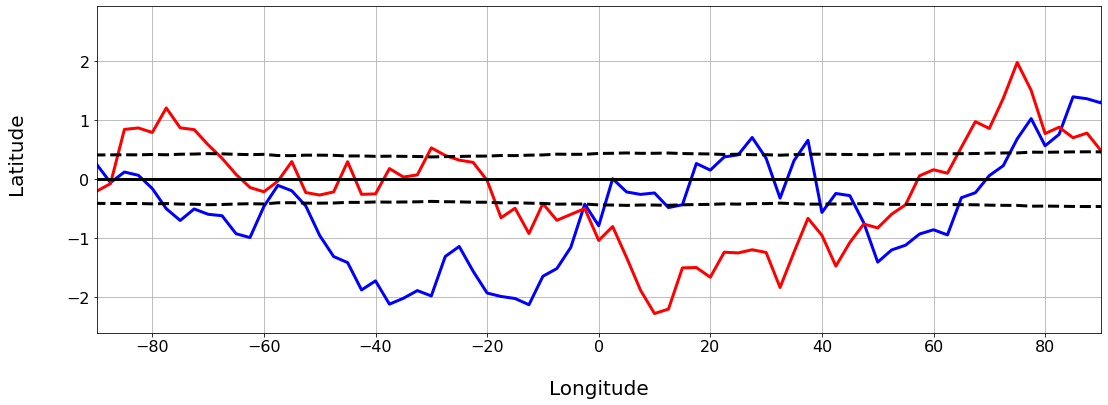

In [105]:
U_comp_cold_diff_wrapped = wrapTo180(U_comp_cold_diff,U_comp_cold_diff.longitude)
U_comp_warm_diff_wrapped = wrapTo180(U_comp_warm_diff,U_comp_warm_diff.longitude)
U_cold_medium_std_diff_wrapped = wrapTo180(U_cold_medium_std_diff,U_cold_medium_std_diff.longitude)
U_warm_medium_std_diff_wrapped = wrapTo180(U_warm_medium_std_diff,U_warm_medium_std_diff.longitude)

# Show North Atlantic European sector
fig = plt.figure(figsize=(18,6))
prj = ccrs.PlateCarree()
#levels= np.linspace(-10,10, 11)
#titles=['1992','1994','2003','2010','2015','2018']
x1, y1 = [-180,180], [0, 0]

axs=[]
for i in range(1,2):
    axs.append(fig.add_subplot(1,1,i))
for i in range(0,1):
    p1 = axs[i].plot(U_comp_cold_diff_wrapped.longitude, U_comp_cold_diff_wrapped, color='blue', linewidth=3)
    p2 = axs[i].plot(U_comp_cold_diff_wrapped.longitude, U_comp_warm_diff_wrapped, color='red', linewidth=3, linestyle='-')
    p3 = axs[i].plot(U_comp_cold_diff_wrapped.longitude, U_cold_medium_std_diff_wrapped, color='black', linewidth=3, linestyle='--')
    p3 = axs[i].plot(U_comp_cold_diff_wrapped.longitude, U_warm_medium_std_diff_wrapped, color='black', linewidth=3, linestyle='--')
    axs[i].plot(x1, y1, color='black', linestyle='-', linewidth=3)

    #axs[i].set_title(titles[i], size=20)

for ax in axs:
    #ax.set_extent([-80, 80, 35, 80], ccrs.PlateCarree())
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.text(0.5, -0.2, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        fontsize =20, transform=ax.transAxes)
    ax.set_xlim([-90, 90])

    #ax.set_xticks([-80, -60, -40, -20,0,20, 40, 60, 80],crs=prj)
    #ax.set_yticks([40, 50, 60, 70,80],crs=prj)
    ax.grid()

plt.savefig('ERA5_U_tot_cold_warm_medium_composite.pdf')
#cb_ax = fig.add_axes([0.2, 0.05, 0.6, 0.04])
#cb = fig.colorbar(cont, cax=cb_ax, orientation='horizontal')
#cb.ax.tick_params(labelsize=20)
#cb.set_label(label='merdidional wind speed anomaly (m/s)', size='large', weight='bold')